# Detecting Multimodal AUC distributions in HNSCC 

We currently assign sensitivities by tail-assignment, however, there may be cases with distinctive multimodal distributions that are indicative of different response models. 

We'll begin by testing the method on beatAML data where we have much greater number of observations, and therefore more well defined distributions. 

$$ p(x) = \frac{1}{\sqrt{ 2 \pi \sigma^2 }} e^{ - \frac{ (x - \mu)^2 } {2 \sigma^2} } $$

In [234]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [235]:
import pandas as pd 
import numpy as np
from sklearn.mixture import GMM
import seaborn as sbn
from matplotlib import pyplot as plt
import warnings

# ------ for mut models ---------
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import statsmodels.api as sm
from sklearn import metrics

warnings.filterwarnings("ignore")

In [236]:
aml_aucs = pd.read_csv('./../data/beatAML_aucs.csv')[['inhibitor','lab_id','auc']].drop_duplicates()

#aml_aucs = pd.read_csv('./../data/beatAML_AUCs_subset.csv')

In [237]:
aml_aucs.head()

inhibitor    lab_id         auc
0   17-AAG (Tanespimycin)  12-00211  225.918025
7   17-AAG (Tanespimycin)  12-00219  135.264409
14  17-AAG (Tanespimycin)  12-00258  164.561227
21  17-AAG (Tanespimycin)  12-00262  111.555971
28  17-AAG (Tanespimycin)  12-00268  226.805281

In [238]:
def add_normal_plot(mu, s, weight, c, ax, auc_max=300): 
    '''
    mu = mean
    s = standard deviation
    ax = matplotlib axes to add to 
    c = color {[r b g c y ...]} <str> 
    '''
    
    x = np.arange(0, auc_max, 1)
    y = (1/(2*np.pi*s**2)**(0.5))*np.exp( - (x-mu)**2/(2*s**2) ) * weight
    
    ax = ax.plot(x,y, color=c, label='mean: %.1f, std: %.1f' %(mu, s))

def get_color():
    '''
    
    '''
    for c in ['r','b','g','c','y']: 
        yield c
    

In [239]:
gen = get_color()
gen.__next__()

'r'

In [240]:
def test_multimodal_fits(X, ntests=10, kmax=5, plot=True, inhib=None, override_k=False): 
    '''
    
    '''
    
    res = {x:[] for x in ['k', 'aic', 'bic']}
    for k in range(1,kmax): 
        for i in range(ntests): 
            
            #print('k: %d' %k)
            gmm = GMM(n_components=k, n_init=1)
            gmm.fit(X)
            res['k'].append( k )
            res['aic'].append( gmm.aic(X) )
            res['bic'].append( gmm.bic(X) )
            
    res = pd.DataFrame( res )
    
    best_k = res[res.bic == np.min(res.bic)].k.unique()[0] if not override_k else override_k
    gmm_best = GMM(n_components=best_k,n_init=20) 
    gmm_best.fit(X)
    P = gmm_best.predict(X)
    
    if plot:         
        nbins = 50
        bin_ = np.arange(0,np.max(X),np.max(X)/nbins)
        
        scalar_to_make_pretty = 0.25 # since our fitted Gaussians are normalized to their weights, they appear smaller
        weights_ = scalar_to_make_pretty/len(X)
        
        f, axs = plt.subplots(1,3,figsize=(15,5)) 
        sbn.distplot(X, bins=bin_, ax=axs[0]).set_title('AUC distribution')
        sbn.scatterplot(x='k', y='bic', alpha=0.3, data=res, ax=axs[1]).set_title('BIC vs K')
        
        clas = 0
        for weight, mean, covars, c in zip(gmm_best.weights_, gmm_best.means_, gmm_best.covars_, get_color()): 
            sbn.distplot(X[P==clas], bins=bin_, kde=False, color=c, ax=axs[2], label='AUC', hist_kws={'weights': [weights_]*len(X[P==clas])})
            add_normal_plot(mean[0], (covars[0])**0.5, weight, c, axs[2], auc_max=np.max(X))
            clas+=1
        
        axs[2].set_title('Optimal GMM fit')
        
        plt.legend()
        plt.suptitle(inhib)
        
        print('Number of assays (aucs): %d' %len(X))
        print('Optimal K: %d [BIC=%.1f]' %(best_k, np.min(res.bic)))
        print('GMM fit:\n\tMixture Weights: %r\n\tMeans: %r\n\tVariances: %r' %(gmm_best.weights_.ravel(), gmm_best.means_.ravel(), gmm_best.covars_.ravel()))
        print('Class counts: %r' %['class %d: %d' %(cl, len(X[P==cl])) for cl in list(set(P))])
        
        plt.show()
        
    return P


------------------------------------------------
Inhibitor:  17-AAG (Tanespimycin)
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4443.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 154.50949899])
	Variances: array([ 2128.91559614])
Class counts: ['class 0: 422']


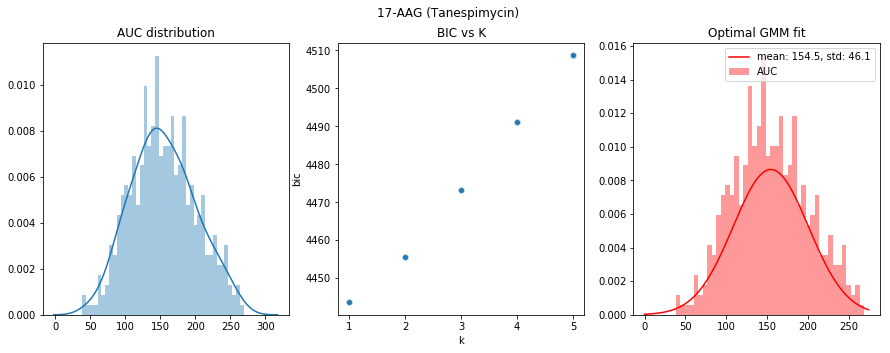

------------------------------------------------
Inhibitor:  A-674563
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 1 [BIC=4651.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 151.07041673])
	Variances: array([ 2329.23070046])
Class counts: ['class 0: 438']


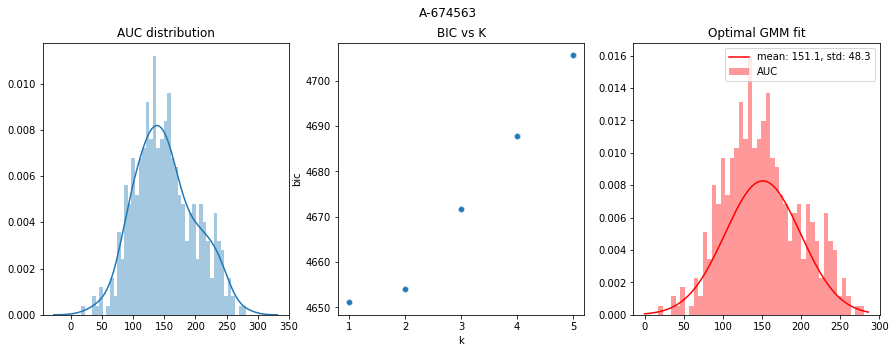

------------------------------------------------
Inhibitor:  Afatinib (BIBW-2992)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4401.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.66455291])
	Variances: array([ 1443.52059549])
Class counts: ['class 0: 434']


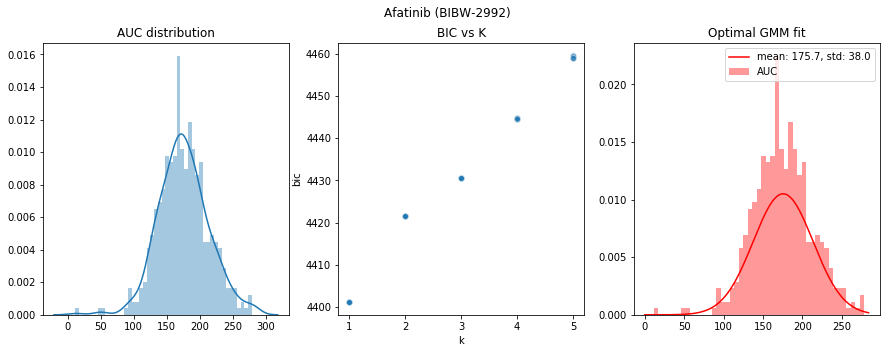

------------------------------------------------
Inhibitor:  Alisertib (MLN8237)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4329.8]
GMM fit:
	Mixture Weights: array([ 0.65671761,  0.34328239])
	Means: array([ 246.26264189,  204.20260238])
	Variances: array([  475.64319411,  1821.18446843])
Class counts: ['class 0: 327', 'class 1: 109']


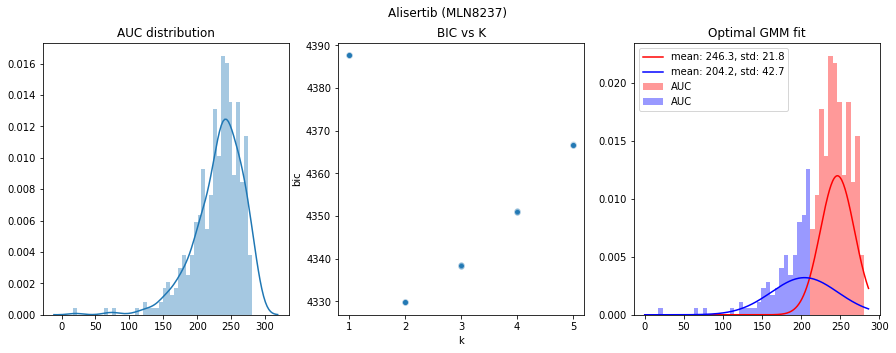

------------------------------------------------
Inhibitor:  AT7519
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 2 [BIC=4229.0]
GMM fit:
	Mixture Weights: array([ 0.75314284,  0.24685716])
	Means: array([ 124.75150735,  178.46550957])
	Variances: array([  563.09991858,  2338.81468744])
Class counts: ['class 0: 358', 'class 1: 64']


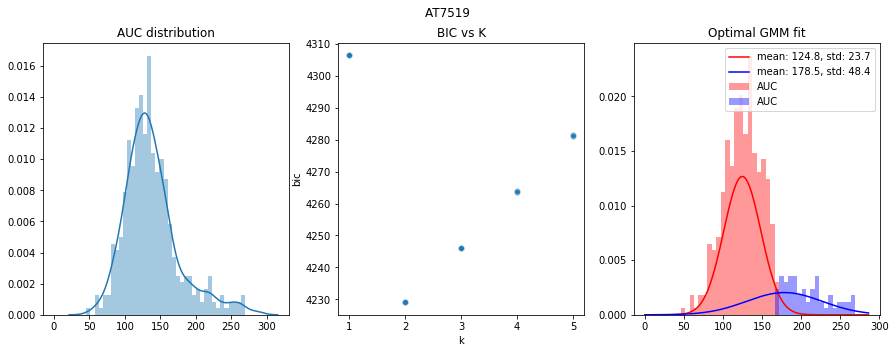

------------------------------------------------
Inhibitor:  Axitinib (AG-013736)
------------------------------------------------
Number of assays (aucs): 489
Optimal K: 1 [BIC=5142.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 196.08068388])
	Variances: array([ 2105.86622831])
Class counts: ['class 0: 489']


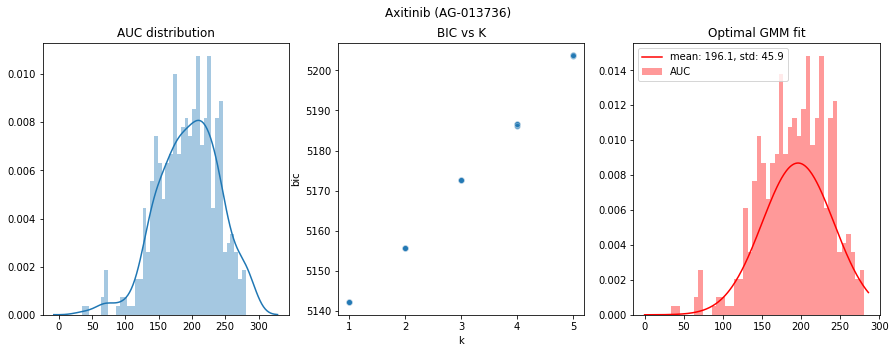

------------------------------------------------
Inhibitor:  AZD1480
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 2 [BIC=4387.8]
GMM fit:
	Mixture Weights: array([ 0.68375826,  0.31624174])
	Means: array([ 237.56460238,  191.00020832])
	Variances: array([  679.35869862,  2623.05171184])
Class counts: ['class 0: 347', 'class 1: 83']


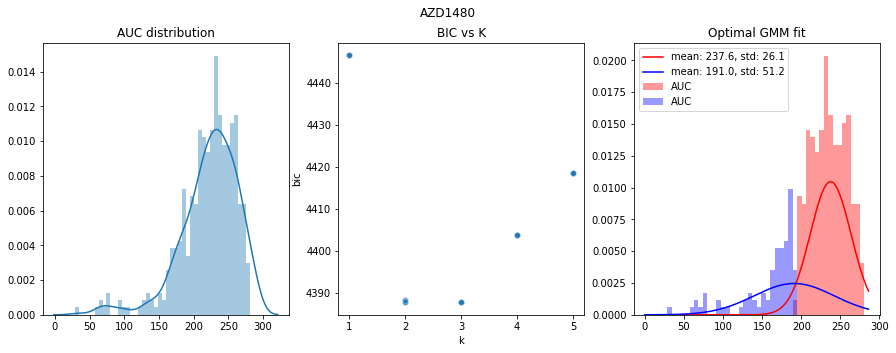

------------------------------------------------
Inhibitor:  Barasertib (AZD1152-HQPA)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 3 [BIC=4460.0]
GMM fit:
	Mixture Weights: array([ 0.11282023,  0.42330403,  0.46387574])
	Means: array([ 132.78487016,  207.89923596,  247.66057351])
	Variances: array([ 2142.92992008,   785.09445571,   367.0611694 ])
Class counts: ['class 0: 38', 'class 1: 166', 'class 2: 230']


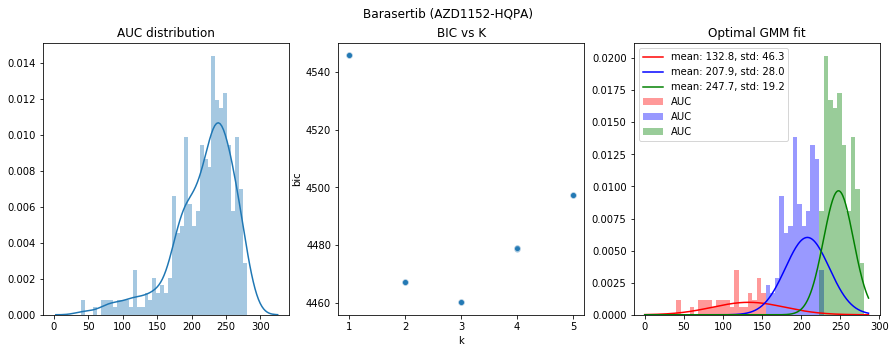

------------------------------------------------
Inhibitor:  BEZ235
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 1 [BIC=4549.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 155.1396563])
	Variances: array([ 2665.87541679])
Class counts: ['class 0: 423']


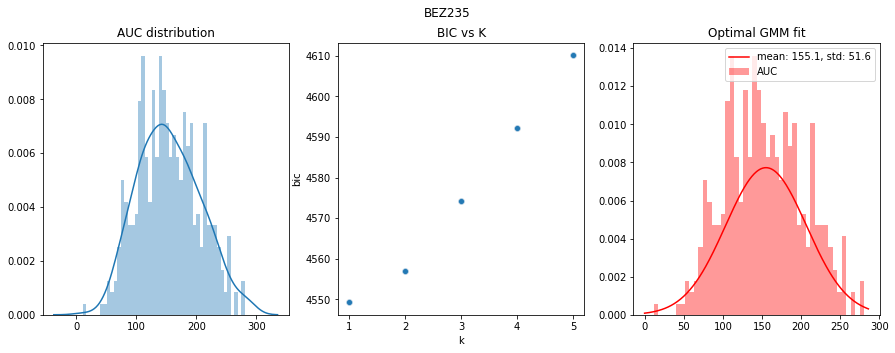

------------------------------------------------
Inhibitor:  BMS-345541
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4153.7]
GMM fit:
	Mixture Weights: array([ 0.6477877,  0.3522123])
	Means: array([ 239.06803525,  209.11838798])
	Variances: array([  323.31946996,  1320.81784771])
Class counts: ['class 0: 345', 'class 1: 91']


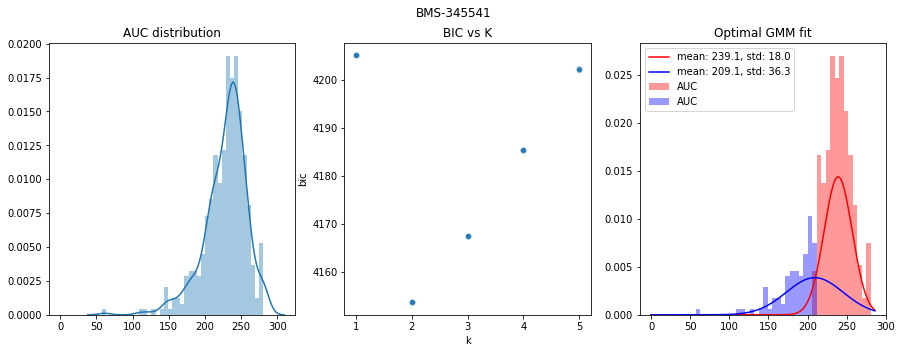

------------------------------------------------
Inhibitor:  Bortezomib (Velcade)
------------------------------------------------
Number of assays (aucs): 448
Optimal K: 1 [BIC=4913.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 158.67686228])
	Variances: array([ 3299.70585455])
Class counts: ['class 0: 448']


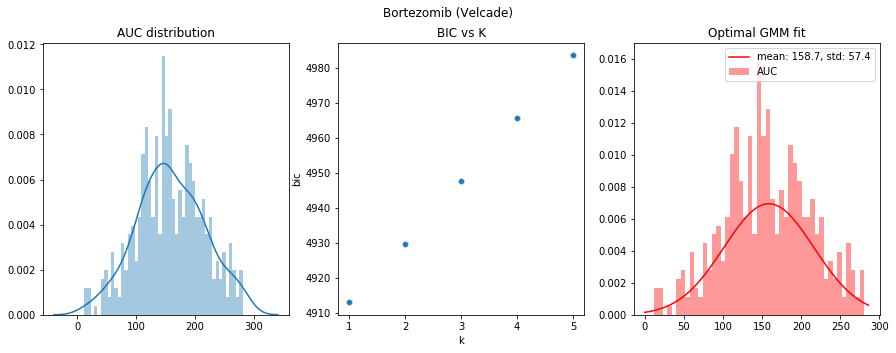

------------------------------------------------
Inhibitor:  Bosutinib (SKI-606)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 1 [BIC=4573.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 203.13102859])
	Variances: array([ 2048.55073521])
Class counts: ['class 0: 436']


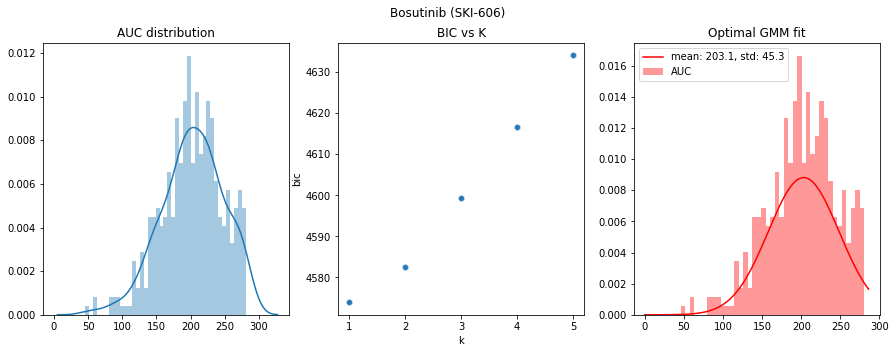

------------------------------------------------
Inhibitor:  Cabozantinib
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4578.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.10654432])
	Variances: array([ 2927.29076442])
Class counts: ['class 0: 422']


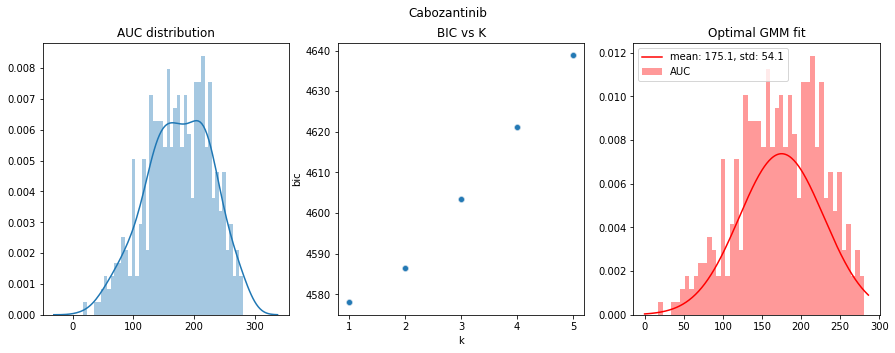

------------------------------------------------
Inhibitor:  Canertinib (CI-1033)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 2 [BIC=4345.4]
GMM fit:
	Mixture Weights: array([ 0.31247043,  0.68752957])
	Means: array([ 195.47543171,  231.11659019])
	Variances: array([ 2461.64893922,   638.25502618])
Class counts: ['class 0: 69', 'class 1: 363']


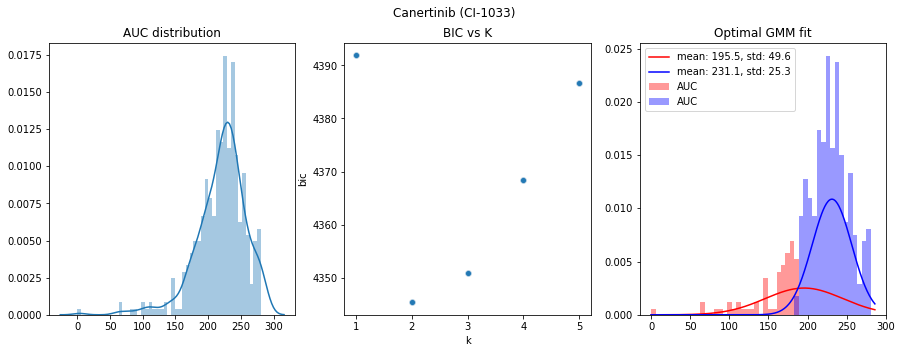

------------------------------------------------
Inhibitor:  Cediranib (AZD2171)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 4 [BIC=4164.4]
GMM fit:
	Mixture Weights: array([ 0.23640054,  0.05168128,  0.30876291,  0.40315527])
	Means: array([ 283.97250267,  127.72808084,  219.89165867,  257.04257597])
	Variances: array([    7.46829461,  2395.2821458 ,   507.29422741,   193.91635147])
Class counts: ['class 0: 109', 'class 1: 21', 'class 2: 126', 'class 3: 177']


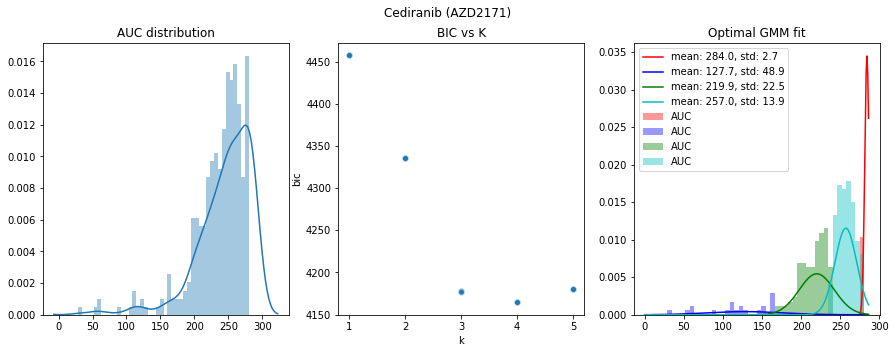

------------------------------------------------
Inhibitor:  CHIR-99021
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 4 [BIC=3099.0]
GMM fit:
	Mixture Weights: array([ 0.47378699,  0.19935972,  0.06532222,  0.26153107])
	Means: array([ 279.27930301,  286.25399414,  189.18746904,  255.4888756 ])
	Variances: array([  2.79197612e+01,   3.26304772e-03,   3.33118011e+03,
         2.16456604e+02])
Class counts: ['class 0: 223', 'class 1: 87', 'class 2: 21', 'class 3: 101']


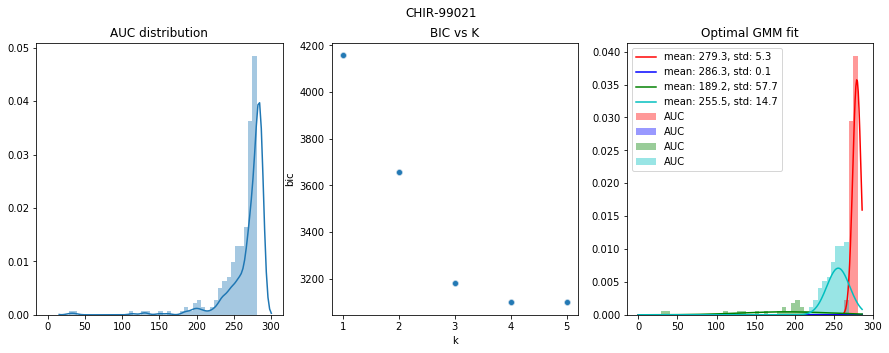

------------------------------------------------
Inhibitor:  CI-1040 (PD184352)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4621.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 186.16710688])
	Variances: array([ 2399.10252514])
Class counts: ['class 0: 434']


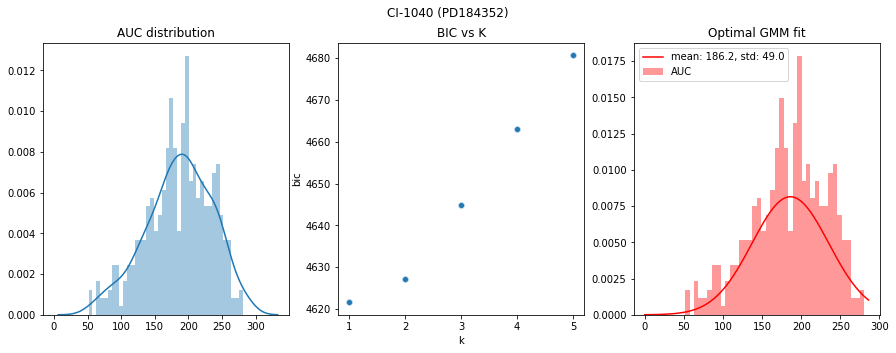

------------------------------------------------
Inhibitor:  Crenolanib
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 2 [BIC=4640.8]
GMM fit:
	Mixture Weights: array([ 0.43941297,  0.56058703])
	Means: array([ 177.61408018,  248.24111318])
	Variances: array([ 2013.7339333 ,   655.29874179])
Class counts: ['class 0: 173', 'class 1: 266']


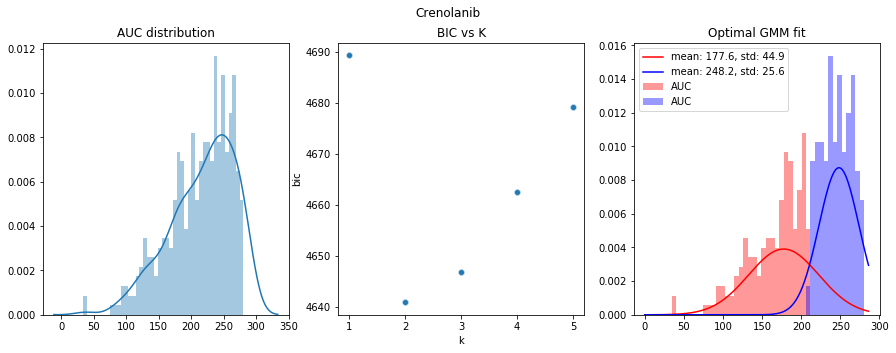

------------------------------------------------
Inhibitor:  Crizotinib (PF-2341066)
------------------------------------------------
Number of assays (aucs): 497
Optimal K: 1 [BIC=5065.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 204.51331279])
	Variances: array([ 1524.50444563])
Class counts: ['class 0: 497']


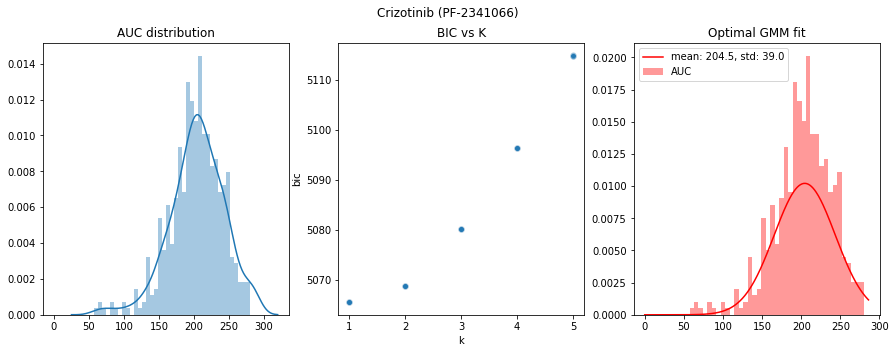

------------------------------------------------
Inhibitor:  CYT387
------------------------------------------------
Number of assays (aucs): 435
Optimal K: 1 [BIC=4568.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 179.54867492])
	Variances: array([ 2072.83764801])
Class counts: ['class 0: 435']


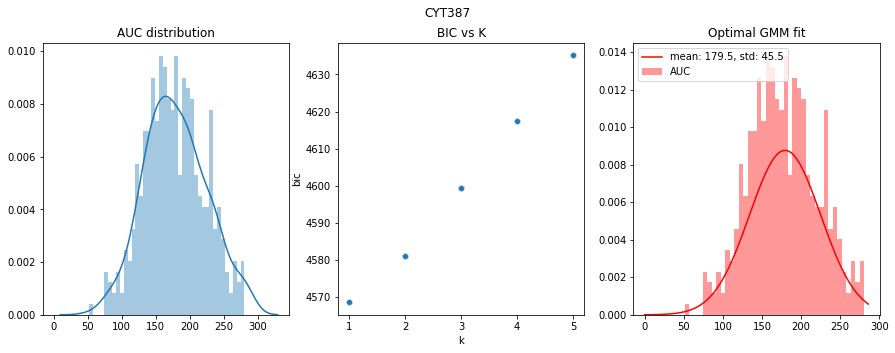

------------------------------------------------
Inhibitor:  Dasatinib
------------------------------------------------
Number of assays (aucs): 500
Optimal K: 2 [BIC=5491.2]
GMM fit:
	Mixture Weights: array([ 0.46625401,  0.53374599])
	Means: array([ 123.37563374,  217.6556194 ])
	Variances: array([ 1380.5881829 ,  1260.94952096])
Class counts: ['class 0: 223', 'class 1: 277']


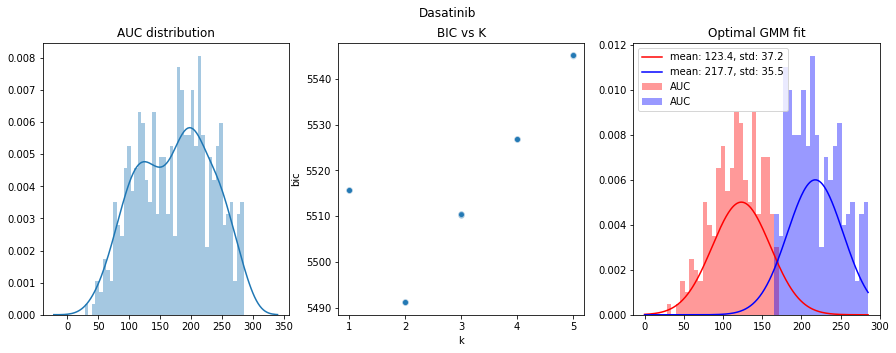

------------------------------------------------
Inhibitor:  Doramapimod (BIRB 796)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4714.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 173.64940363])
	Variances: array([ 3121.23762535])
Class counts: ['class 0: 432']


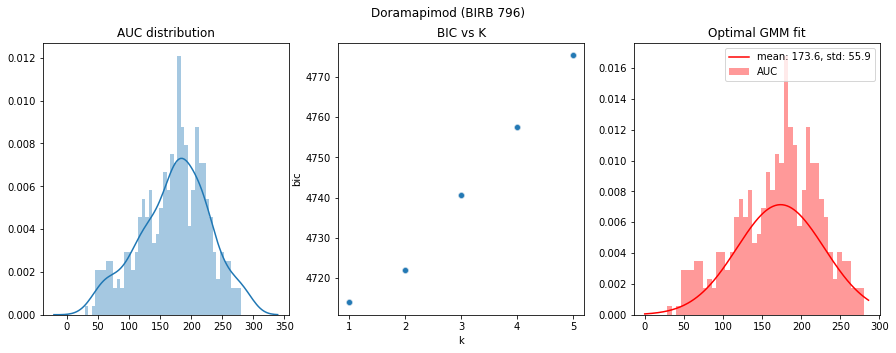

------------------------------------------------
Inhibitor:  Dovitinib (CHIR-258)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 1 [BIC=4654.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 156.66310314])
	Variances: array([ 2589.11075512])
Class counts: ['class 0: 434']


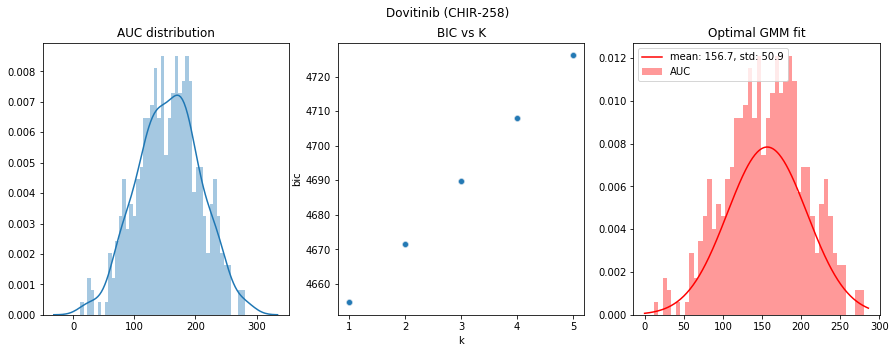

------------------------------------------------
Inhibitor:  Elesclomol
------------------------------------------------
Number of assays (aucs): 401
Optimal K: 3 [BIC=4037.7]
GMM fit:
	Mixture Weights: array([ 0.39585498,  0.51174539,  0.09239963])
	Means: array([  66.66850544,   26.350298  ,  203.44968902])
	Variances: array([  612.43965939,   166.22601469,  2510.66009017])
Class counts: ['class 0: 144', 'class 1: 221', 'class 2: 36']


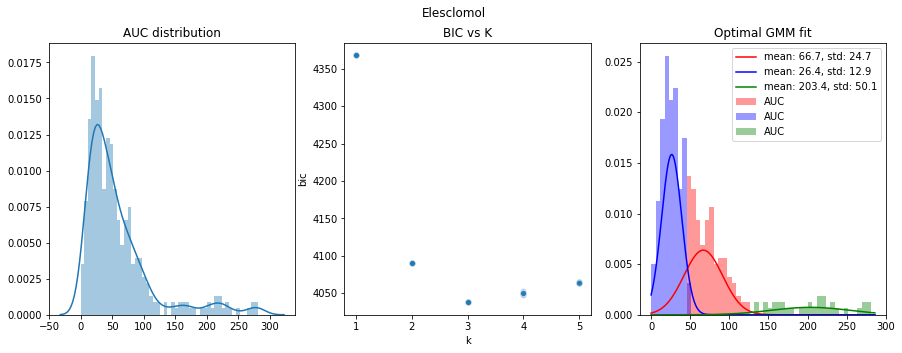

------------------------------------------------
Inhibitor:  Erlotinib
------------------------------------------------
Number of assays (aucs): 494
Optimal K: 2 [BIC=4859.8]
GMM fit:
	Mixture Weights: array([ 0.61873948,  0.38126052])
	Means: array([ 245.28723167,  206.3491596 ])
	Variances: array([  454.2151368 ,  1366.94034476])
Class counts: ['class 0: 360', 'class 1: 134']


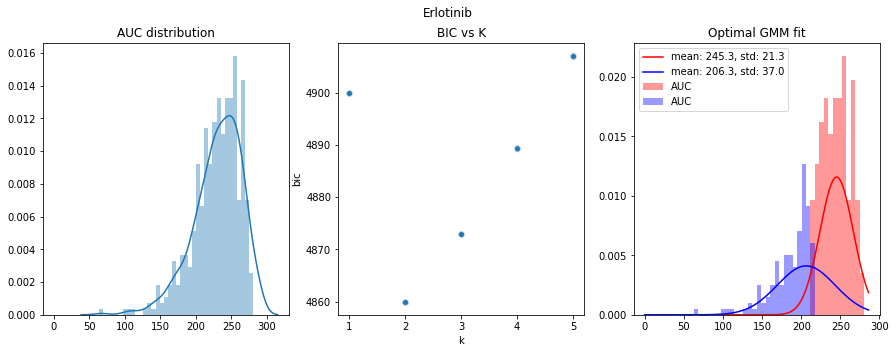

------------------------------------------------
Inhibitor:  Flavopiridol
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 2 [BIC=4672.4]
GMM fit:
	Mixture Weights: array([ 0.66508816,  0.33491184])
	Means: array([ 103.66651482,  186.28874937])
	Variances: array([  988.81044947,  3253.09454755])
Class counts: ['class 0: 318', 'class 1: 115']


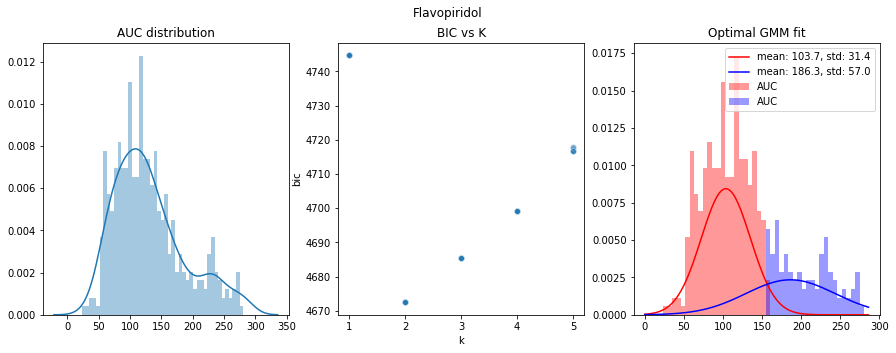

------------------------------------------------
Inhibitor:  Foretinib (XL880)
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 1 [BIC=4644.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 130.15626445])
	Variances: array([ 2791.87918259])
Class counts: ['class 0: 430']


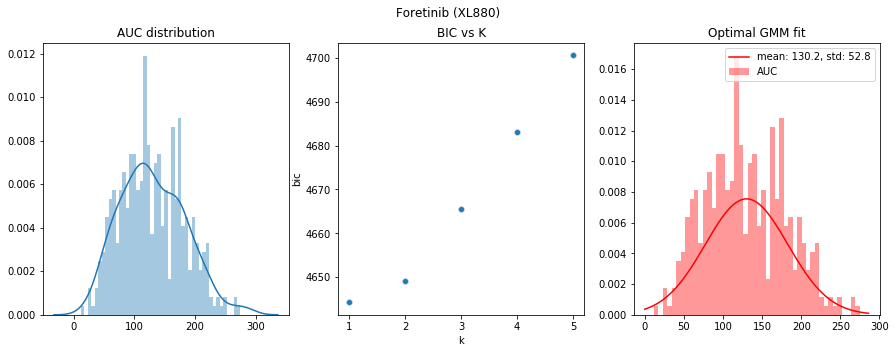

------------------------------------------------
Inhibitor:  GDC-0879
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 4 [BIC=2652.8]
GMM fit:
	Mixture Weights: array([ 0.53577316,  0.14364301,  0.28795058,  0.03263325])
	Means: array([ 278.26202817,  242.00450312,  286.26518616,  156.32321761])
	Variances: array([  5.89027441e+01,   5.72554080e+02,   1.60742379e-03,
         2.37646334e+03])
Class counts: ['class 0: 242', 'class 1: 54', 'class 2: 126', 'class 3: 11']


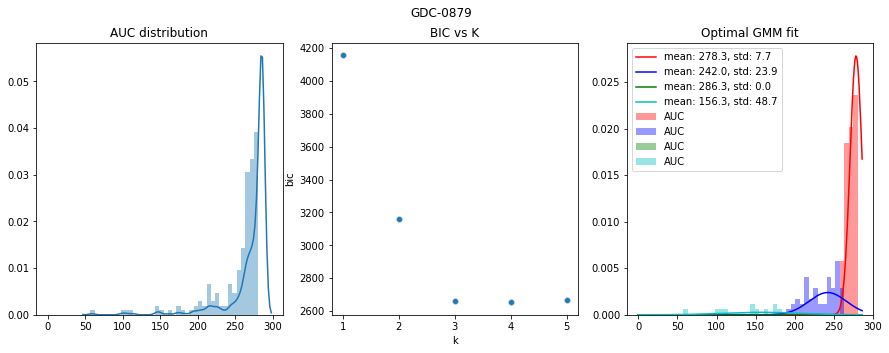

------------------------------------------------
Inhibitor:  GDC-0941
------------------------------------------------
Number of assays (aucs): 403
Optimal K: 1 [BIC=4211.5]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 155.88303782])
	Variances: array([ 1964.208886])
Class counts: ['class 0: 403']


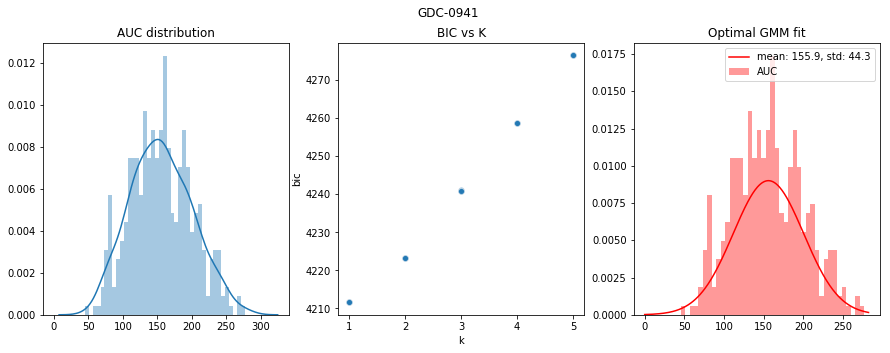

------------------------------------------------
Inhibitor:  Gefitinib
------------------------------------------------
Number of assays (aucs): 492
Optimal K: 2 [BIC=4781.7]
GMM fit:
	Mixture Weights: array([ 0.66870742,  0.33129258])
	Means: array([ 253.3594795 ,  216.04175397])
	Variances: array([  403.86181731,  1573.84847907])
Class counts: ['class 0: 390', 'class 1: 102']


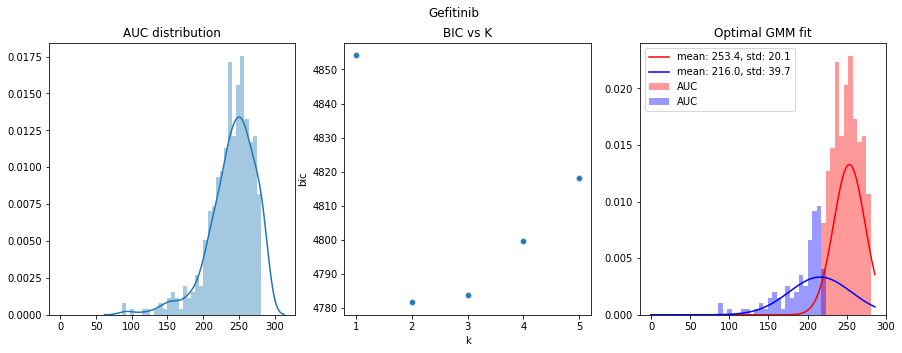

------------------------------------------------
Inhibitor:  GSK-1838705A
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4379.6]
GMM fit:
	Mixture Weights: array([ 0.64441178,  0.35558822])
	Means: array([ 226.23377434,  193.51224229])
	Variances: array([  762.09370287,  2589.28618581])
Class counts: ['class 0: 356', 'class 1: 73']


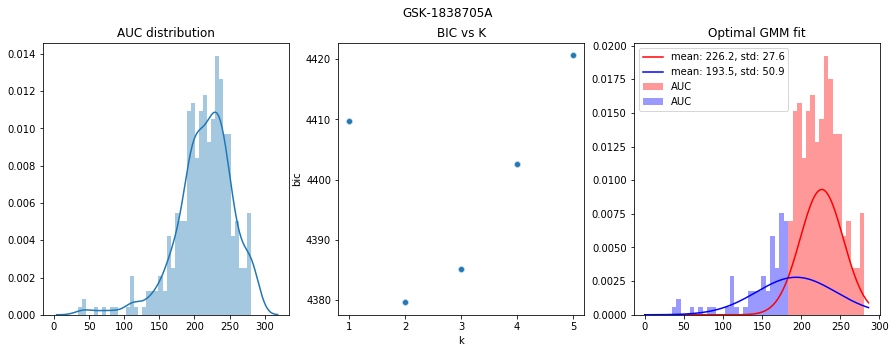

------------------------------------------------
Inhibitor:  GSK-1904529A
------------------------------------------------
Number of assays (aucs): 424
Optimal K: 2 [BIC=4170.1]
GMM fit:
	Mixture Weights: array([ 0.70313758,  0.29686242])
	Means: array([ 254.02621907,  201.15845045])
	Variances: array([  364.60097096,  1884.17926715])
Class counts: ['class 0: 328', 'class 1: 96']


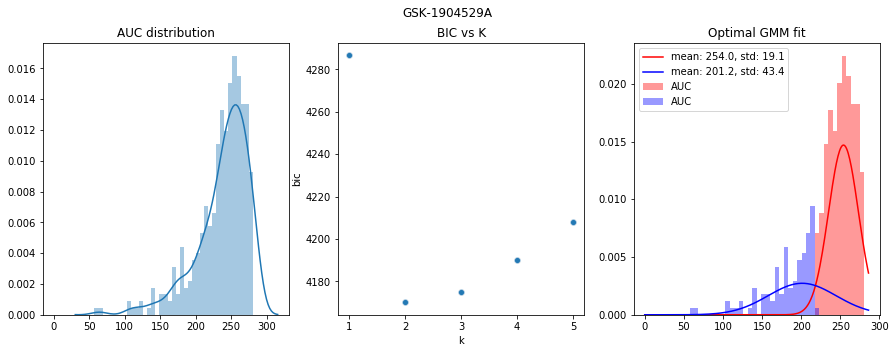

------------------------------------------------
Inhibitor:  GSK690693
------------------------------------------------
Number of assays (aucs): 424
Optimal K: 3 [BIC=4242.0]
GMM fit:
	Mixture Weights: array([ 0.46017142,  0.42038574,  0.11944283])
	Means: array([ 260.41512784,  224.76638262,  177.41892221])
	Variances: array([  270.75592078,   806.35712071,  3068.87989479])
Class counts: ['class 0: 234', 'class 1: 165', 'class 2: 25']


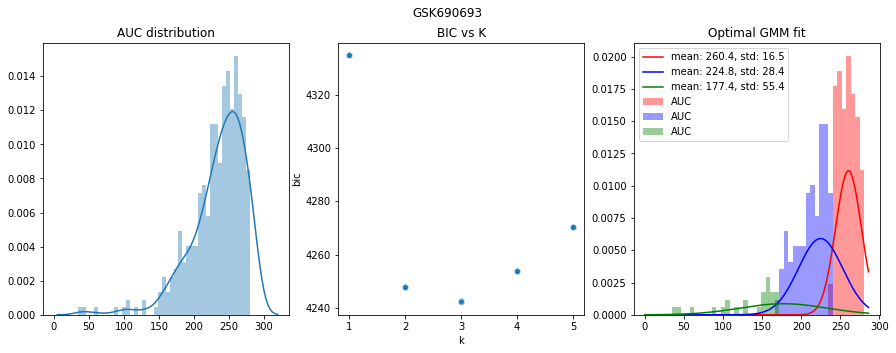

------------------------------------------------
Inhibitor:  GW-2580
------------------------------------------------
Number of assays (aucs): 417
Optimal K: 1 [BIC=4276.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 213.82657202])
	Variances: array([ 1616.7423152])
Class counts: ['class 0: 417']


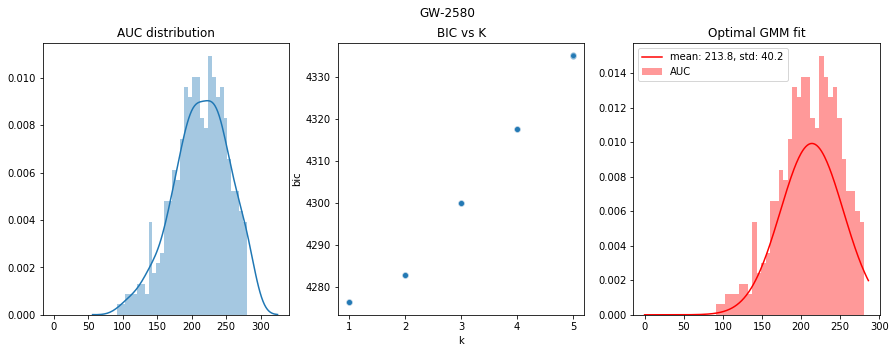

------------------------------------------------
Inhibitor:  H-89
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 3 [BIC=4354.2]
GMM fit:
	Mixture Weights: array([ 0.44556323,  0.07765988,  0.4767769 ])
	Means: array([ 219.96118636,  132.16485483,  260.76639285])
	Variances: array([  640.49591888,  2634.86588413,   245.85984071])
Class counts: ['class 0: 190', 'class 1: 24', 'class 2: 219']


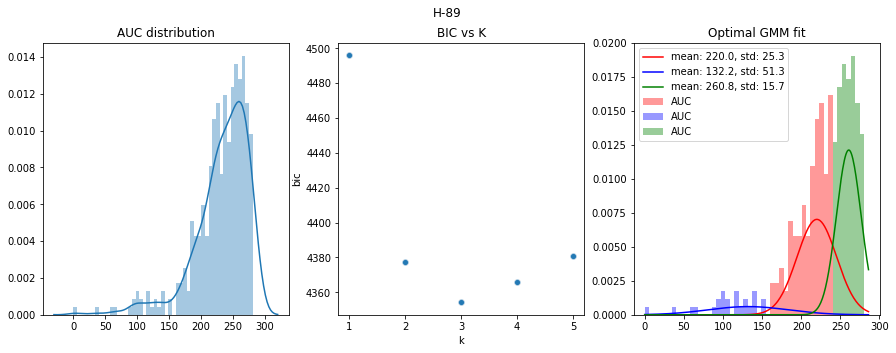

------------------------------------------------
Inhibitor:  Ibrutinib (PCI-32765)
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 4 [BIC=4457.9]
GMM fit:
	Mixture Weights: array([ 0.28047557,  0.27262629,  0.15585869,  0.29103945])
	Means: array([ 196.81052256,  263.55051237,  141.93942592,  210.90953113])
	Variances: array([  871.30855604,   212.01352165,  1849.94058516,   821.13506966])
Class counts: ['class 0: 120', 'class 1: 135', 'class 2: 54', 'class 3: 111']


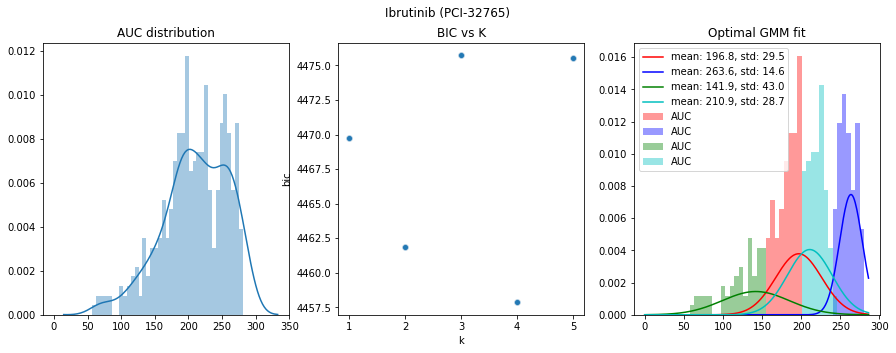

------------------------------------------------
Inhibitor:  Idelalisib
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 1 [BIC=4520.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 192.43172531])
	Variances: array([ 2143.73346977])
Class counts: ['class 0: 429']


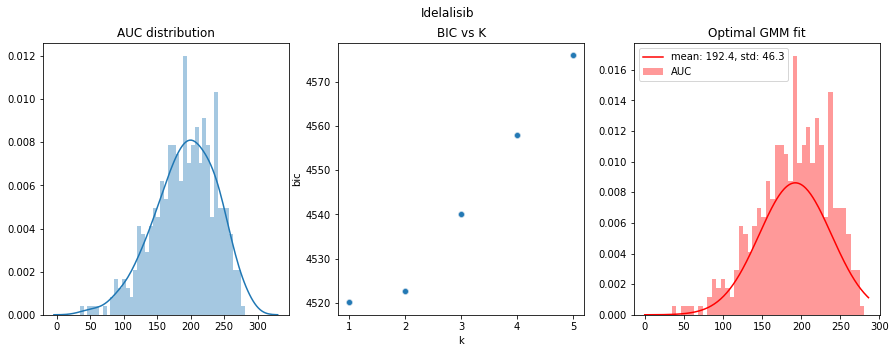

------------------------------------------------
Inhibitor:  Imatinib
------------------------------------------------
Number of assays (aucs): 511
Optimal K: 3 [BIC=5165.5]
GMM fit:
	Mixture Weights: array([ 0.43649856,  0.13105134,  0.43245011])
	Means: array([ 252.62014183,  172.5744297 ,  227.366578  ])
	Variances: array([  470.51400222,  3191.54285991,   882.98703283])
Class counts: ['class 0: 275', 'class 1: 40', 'class 2: 196']


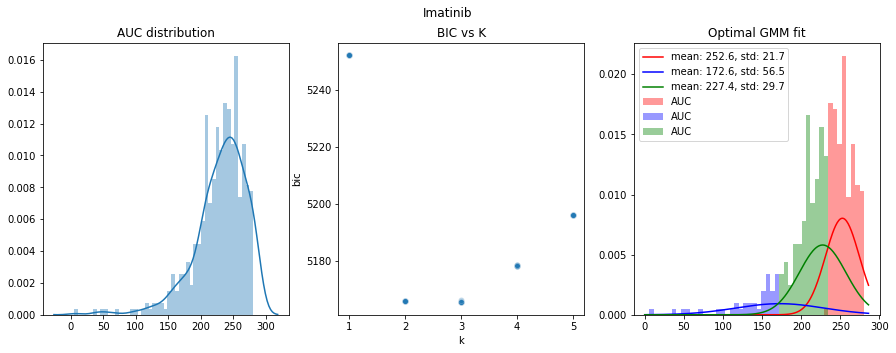

------------------------------------------------
Inhibitor:  INK-128
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 1 [BIC=4684.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 128.60194517])
	Variances: array([ 2642.44890348])
Class counts: ['class 0: 436']


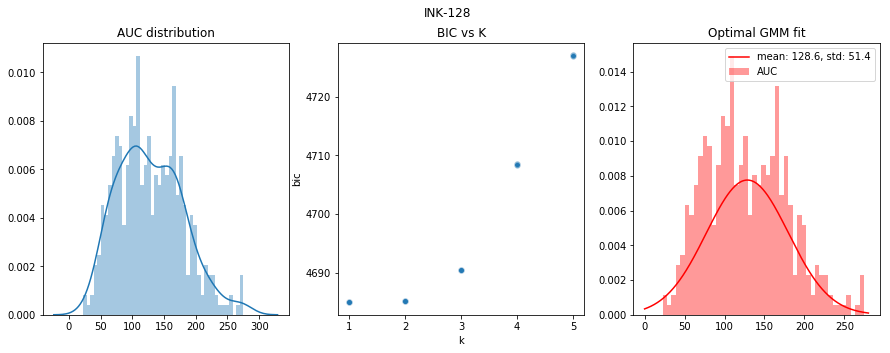

------------------------------------------------
Inhibitor:  JAK Inhibitor I
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 1 [BIC=4573.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 176.23799769])
	Variances: array([ 2198.36538808])
Class counts: ['class 0: 433']


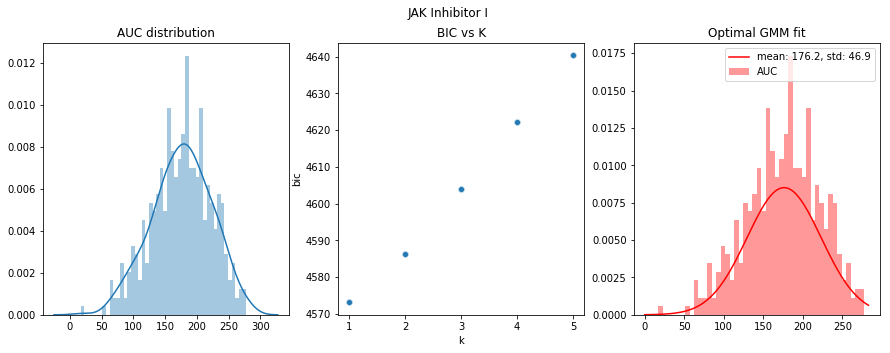

------------------------------------------------
Inhibitor:  JNJ-28312141
------------------------------------------------
Number of assays (aucs): 419
Optimal K: 1 [BIC=4639.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 143.79579035])
	Variances: array([ 3661.97483019])
Class counts: ['class 0: 419']


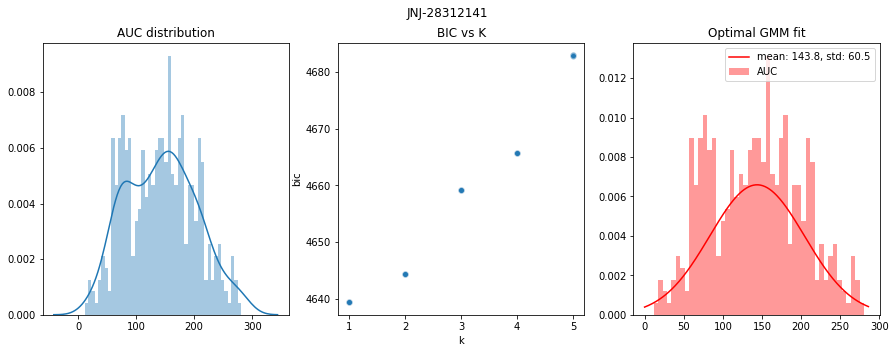

------------------------------------------------
Inhibitor:  JNJ-38877605
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 2 [BIC=4131.4]
GMM fit:
	Mixture Weights: array([ 0.6485401,  0.3514599])
	Means: array([ 251.43303916,  211.76297738])
	Variances: array([  358.82681272,  1494.04817435])
Class counts: ['class 0: 321', 'class 1: 104']


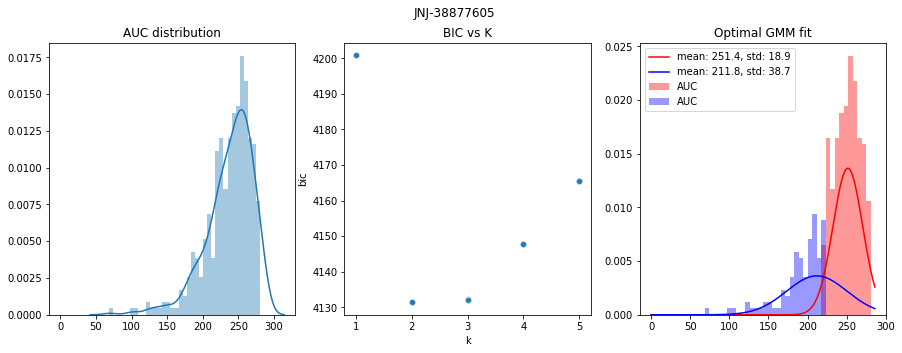

------------------------------------------------
Inhibitor:  JNJ-7706621
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 2 [BIC=4229.8]
GMM fit:
	Mixture Weights: array([ 0.37723995,  0.62276005])
	Means: array([ 215.19081449,  246.25624382])
	Variances: array([ 1161.36983171,   407.01468393])
Class counts: ['class 0: 107', 'class 1: 332']


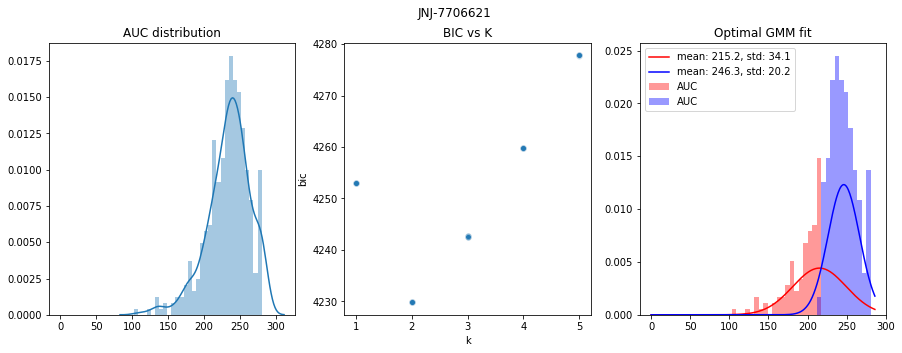

------------------------------------------------
Inhibitor:  KI20227
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 3 [BIC=4749.2]
GMM fit:
	Mixture Weights: array([ 0.3171119 ,  0.27280464,  0.41008347])
	Means: array([ 137.95920933,  256.8800191 ,  175.77865303])
	Variances: array([ 2497.75769925,   424.28392808,  1486.6370125 ])
Class counts: ['class 0: 99', 'class 1: 129', 'class 2: 202']


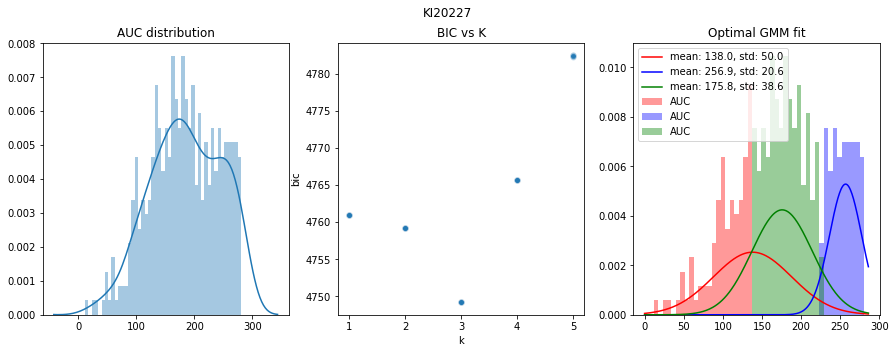

------------------------------------------------
Inhibitor:  KU-55933
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 4 [BIC=4233.9]
GMM fit:
	Mixture Weights: array([ 0.2168071 ,  0.22699107,  0.52011937,  0.03608246])
	Means: array([ 280.14895141,  200.92790729,  245.93409938,   98.32525447])
	Variances: array([  27.28164358,  944.71782655,  279.2877125 ,  857.09319743])
Class counts: ['class 0: 102', 'class 1: 74', 'class 2: 235', 'class 3: 14']


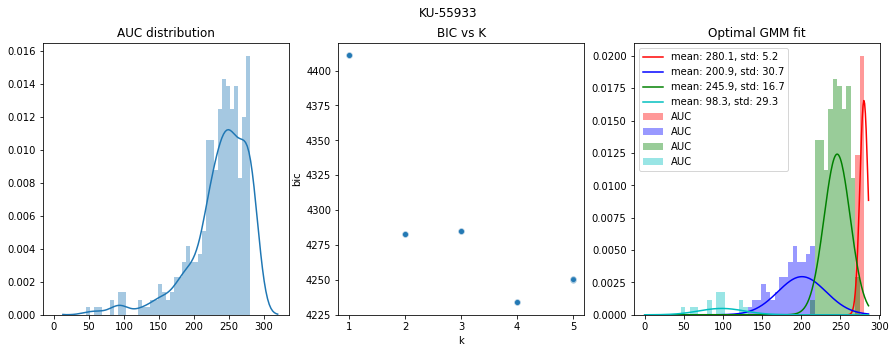

------------------------------------------------
Inhibitor:  KW-2449
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4616.7]
GMM fit:
	Mixture Weights: array([ 0.63031451,  0.36968549])
	Means: array([ 229.26869132,  158.53025873])
	Variances: array([ 1016.70709533,  3259.32200637])
Class counts: ['class 0: 305', 'class 1: 124']


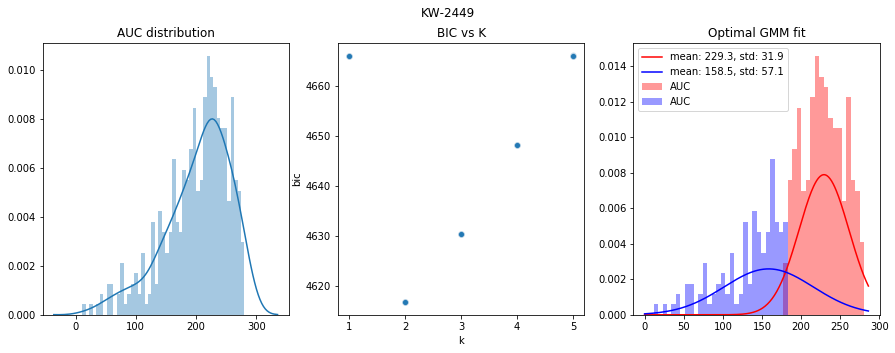

------------------------------------------------
Inhibitor:  Lapatinib
------------------------------------------------
Number of assays (aucs): 485
Optimal K: 2 [BIC=4735.0]
GMM fit:
	Mixture Weights: array([ 0.62840485,  0.37159515])
	Means: array([ 243.08928529,  212.13786003])
	Variances: array([  455.4886863 ,  1530.34760838])
Class counts: ['class 0: 384', 'class 1: 101']


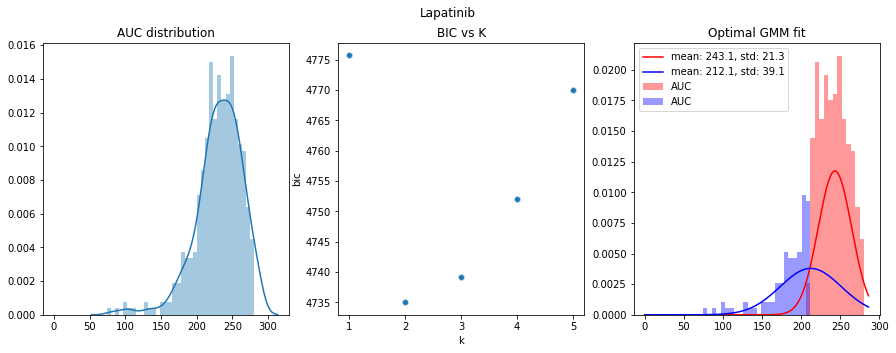

------------------------------------------------
Inhibitor:  Linifanib (ABT-869)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4685.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 195.94696577])
	Variances: array([ 2920.83261464])
Class counts: ['class 0: 432']


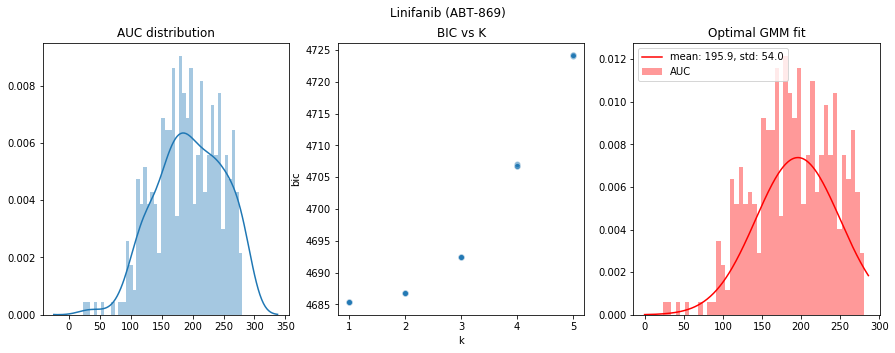

------------------------------------------------
Inhibitor:  LY-333531
------------------------------------------------
Number of assays (aucs): 439
Optimal K: 1 [BIC=4394.3]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 214.16070378])
	Variances: array([ 1266.78532184])
Class counts: ['class 0: 439']


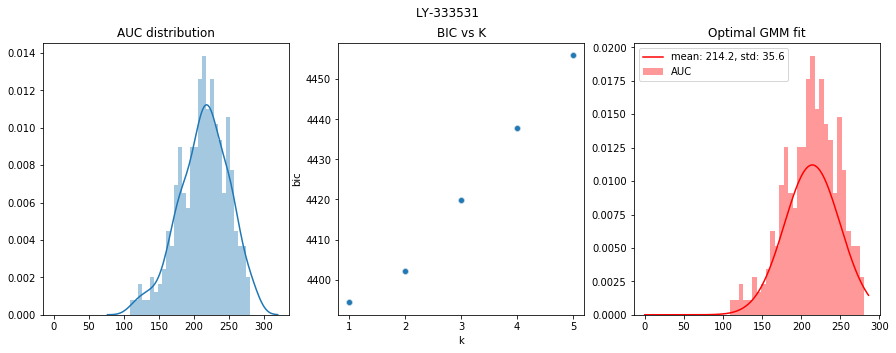

------------------------------------------------
Inhibitor:  Masitinib (AB-1010)
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 2 [BIC=4474.0]
GMM fit:
	Mixture Weights: array([ 0.55508354,  0.44491646])
	Means: array([ 222.86560546,  175.25690805])
	Variances: array([ 1032.22919725,  2272.65262218])
Class counts: ['class 0: 280', 'class 1: 145']


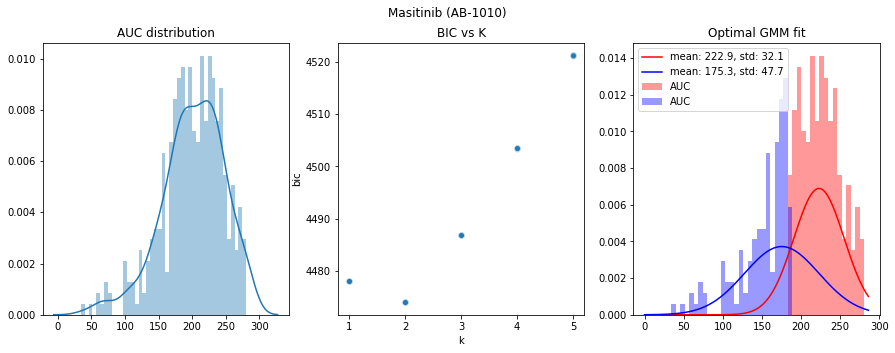

------------------------------------------------
Inhibitor:  MGCD-265
------------------------------------------------
Number of assays (aucs): 421
Optimal K: 2 [BIC=4437.3]
GMM fit:
	Mixture Weights: array([ 0.60141013,  0.39858987])
	Means: array([ 226.75035944,  170.34761683])
	Variances: array([  882.1768398 ,  2584.41478179])
Class counts: ['class 0: 292', 'class 1: 129']


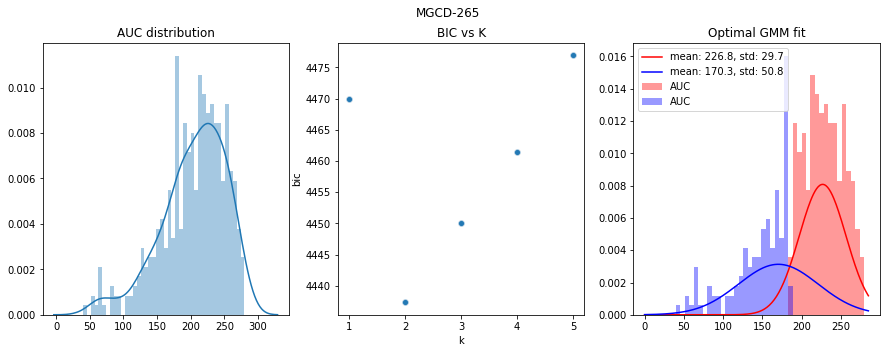

------------------------------------------------
Inhibitor:  Midostaurin
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 2 [BIC=4531.6]
GMM fit:
	Mixture Weights: array([ 0.58642892,  0.41357108])
	Means: array([ 227.68028735,  166.49952623])
	Variances: array([ 1126.34757812,  2602.54914629])
Class counts: ['class 0: 291', 'class 1: 132']


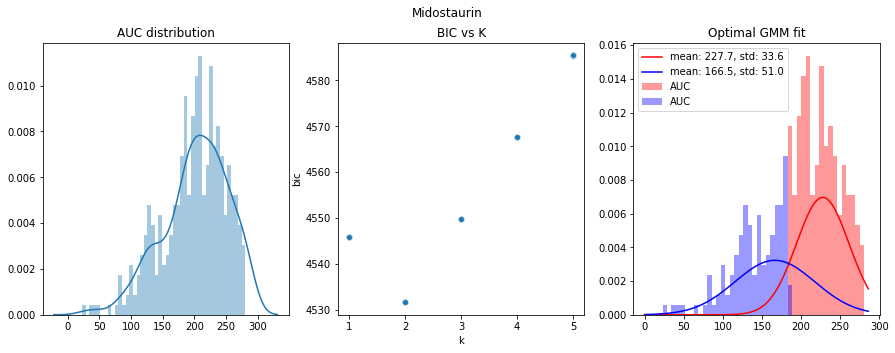

------------------------------------------------
Inhibitor:  MK-2206
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 2 [BIC=4559.8]
GMM fit:
	Mixture Weights: array([ 0.50416044,  0.49583956])
	Means: array([ 245.37914994,  166.09399066])
	Variances: array([  823.23414807,  2397.58311345])
Class counts: ['class 0: 228', 'class 1: 192']


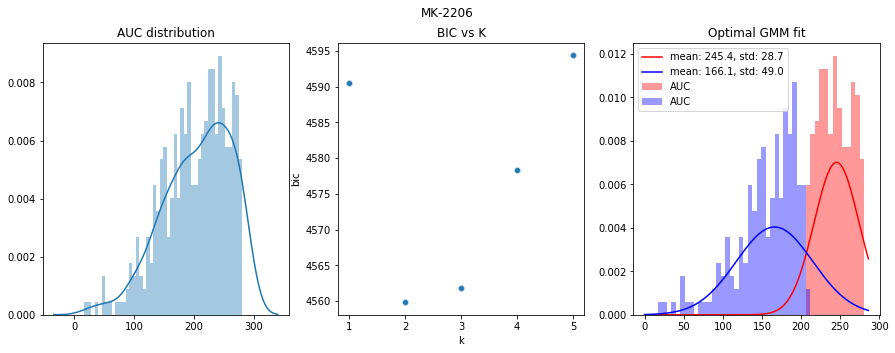

------------------------------------------------
Inhibitor:  MLN120B
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 2 [BIC=4298.1]
GMM fit:
	Mixture Weights: array([ 0.29395022,  0.70604978])
	Means: array([ 198.04981999,  246.5592976 ])
	Variances: array([ 2515.00648811,   512.24469362])
Class counts: ['class 0: 81', 'class 1: 348']


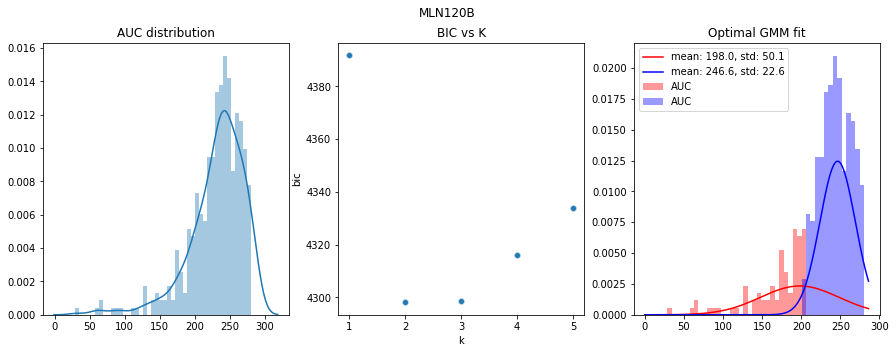

------------------------------------------------
Inhibitor:  MLN8054
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 3 [BIC=4061.0]
GMM fit:
	Mixture Weights: array([ 0.42421821,  0.04131891,  0.53446289])
	Means: array([ 234.11493397,  153.44440356,  267.65559879])
	Variances: array([  536.75459877,  2563.30679427,   172.54266119])
Class counts: ['class 0: 159', 'class 1: 13', 'class 2: 255']


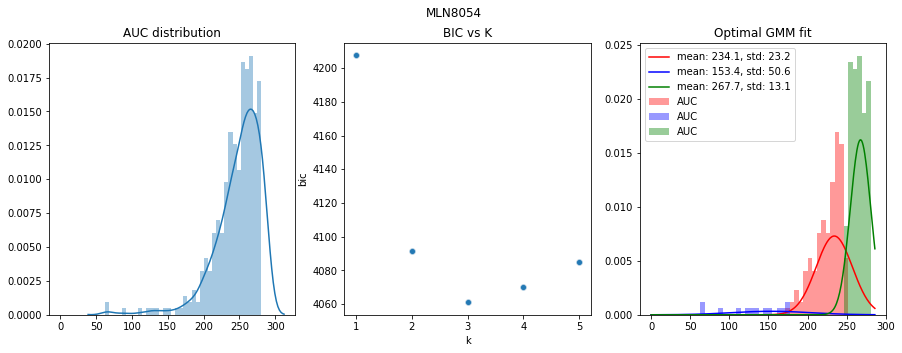

------------------------------------------------
Inhibitor:  Motesanib (AMG-706)
------------------------------------------------
Number of assays (aucs): 430
Optimal K: 4 [BIC=4475.2]
GMM fit:
	Mixture Weights: array([ 0.41972589,  0.29617478,  0.01386803,  0.2702313 ])
	Means: array([ 235.59749621,  175.80564804,   36.11699075,  277.76626574])
	Variances: array([ 529.63868223,  890.28981989,  356.8966111 ,   64.35017609])
Class counts: ['class 0: 177', 'class 1: 122', 'class 2: 6', 'class 3: 125']


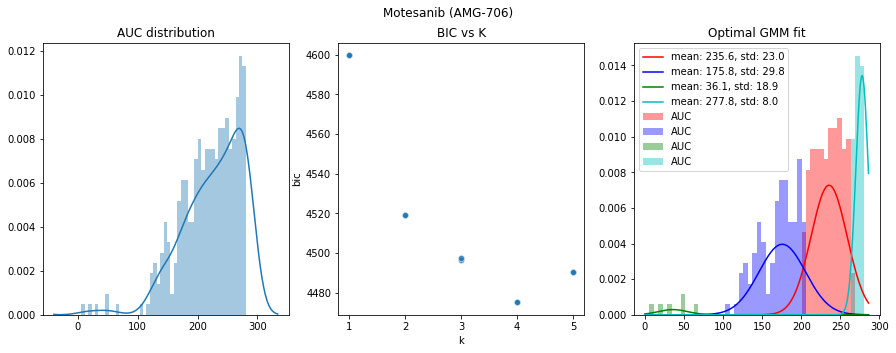

------------------------------------------------
Inhibitor:  Neratinib (HKI-272)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 1 [BIC=4559.0]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 161.97390563])
	Variances: array([ 2127.98147262])
Class counts: ['class 0: 433']


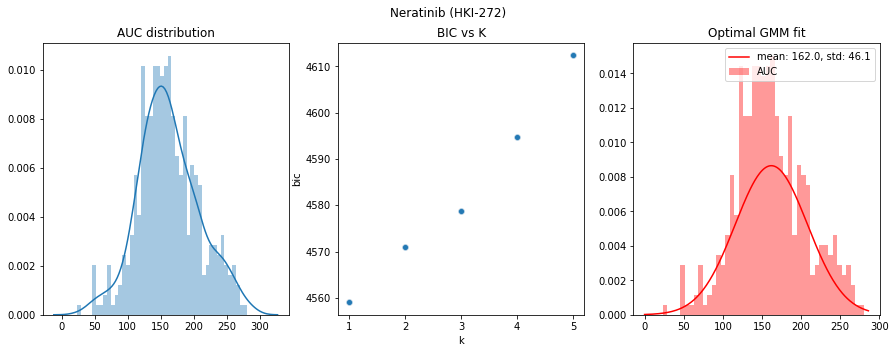

------------------------------------------------
Inhibitor:  NF-kB Activation Inhibitor
------------------------------------------------
Number of assays (aucs): 418
Optimal K: 2 [BIC=4488.9]
GMM fit:
	Mixture Weights: array([ 0.43206445,  0.56793555])
	Means: array([ 169.84052048,  236.13132438])
	Variances: array([ 2391.66716612,  1080.33285254])
Class counts: ['class 0: 155', 'class 1: 263']


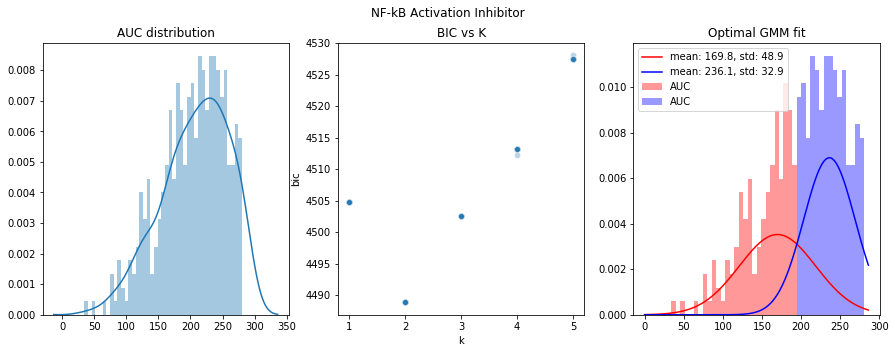

------------------------------------------------
Inhibitor:  Nilotinib
------------------------------------------------
Number of assays (aucs): 495
Optimal K: 2 [BIC=5019.4]
GMM fit:
	Mixture Weights: array([ 0.50233536,  0.49766464])
	Means: array([ 199.7455403 ,  255.40790252])
	Variances: array([ 1001.10418362,   462.24300534])
Class counts: ['class 0: 237', 'class 1: 258']


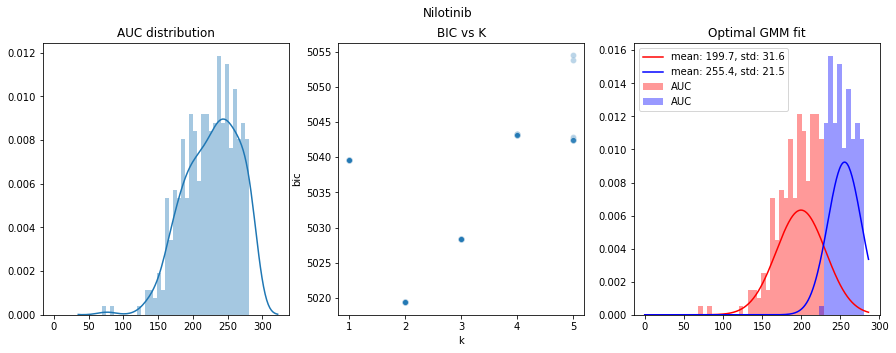

------------------------------------------------
Inhibitor:  NVP-ADW742
------------------------------------------------
Number of assays (aucs): 415
Optimal K: 2 [BIC=4184.6]
GMM fit:
	Mixture Weights: array([ 0.38448161,  0.61551839])
	Means: array([ 197.1292676 ,  231.11355308])
	Variances: array([ 1978.51115865,   648.79332419])
Class counts: ['class 0: 94', 'class 1: 321']


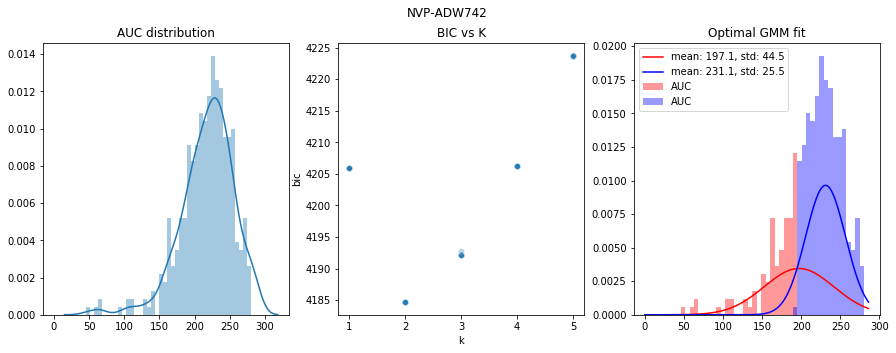

------------------------------------------------
Inhibitor:  NVP-TAE684
------------------------------------------------
Number of assays (aucs): 431
Optimal K: 2 [BIC=4590.9]
GMM fit:
	Mixture Weights: array([ 0.45489171,  0.54510829])
	Means: array([ 167.20448511,  221.22073727])
	Variances: array([ 2355.45307089,  1142.53235091])
Class counts: ['class 0: 168', 'class 1: 263']


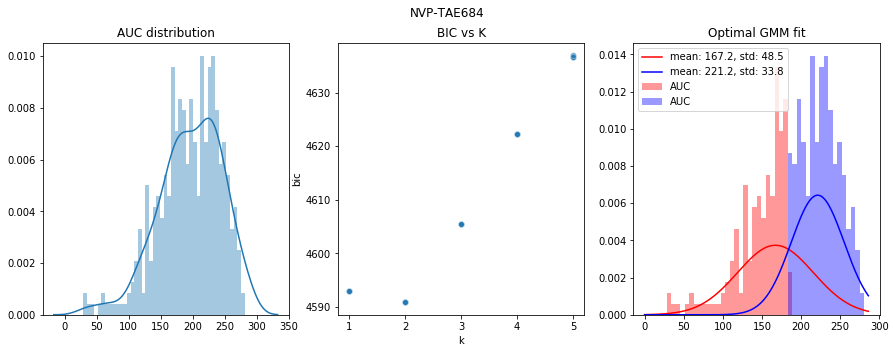

------------------------------------------------
Inhibitor:  Pazopanib (GW786034)
------------------------------------------------
Number of assays (aucs): 486
Optimal K: 2 [BIC=5087.4]
GMM fit:
	Mixture Weights: array([ 0.43753845,  0.56246155])
	Means: array([ 188.62149669,  237.73450149])
	Variances: array([ 2163.34416825,   926.376757  ])
Class counts: ['class 0: 162', 'class 1: 324']


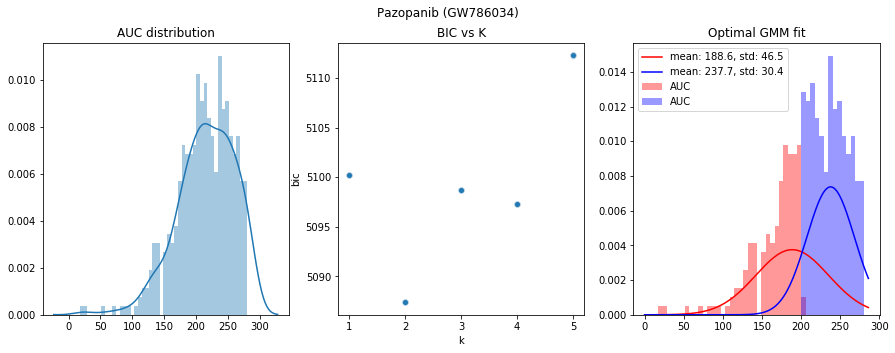

------------------------------------------------
Inhibitor:  PD173955
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 2 [BIC=4731.5]
GMM fit:
	Mixture Weights: array([ 0.48164482,  0.51835518])
	Means: array([ 157.14386309,  237.10121396])
	Variances: array([ 2048.8404387 ,  1138.17244864])
Class counts: ['class 0: 198', 'class 1: 236']


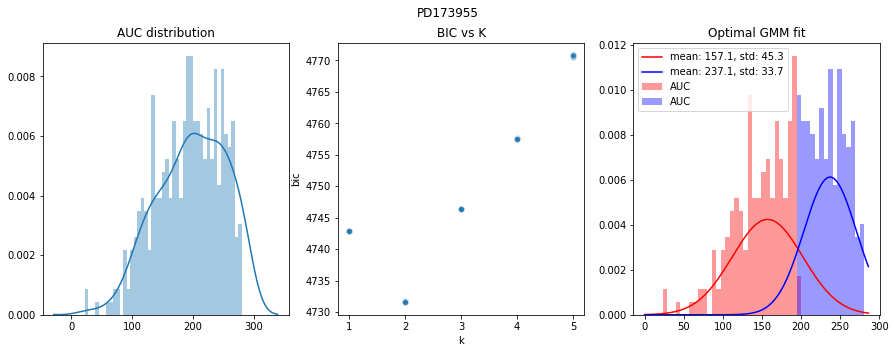

------------------------------------------------
Inhibitor:  Pelitinib (EKB-569)
------------------------------------------------
Number of assays (aucs): 431
Optimal K: 1 [BIC=4461.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 163.13544434])
	Variances: array([ 1783.6839003])
Class counts: ['class 0: 431']


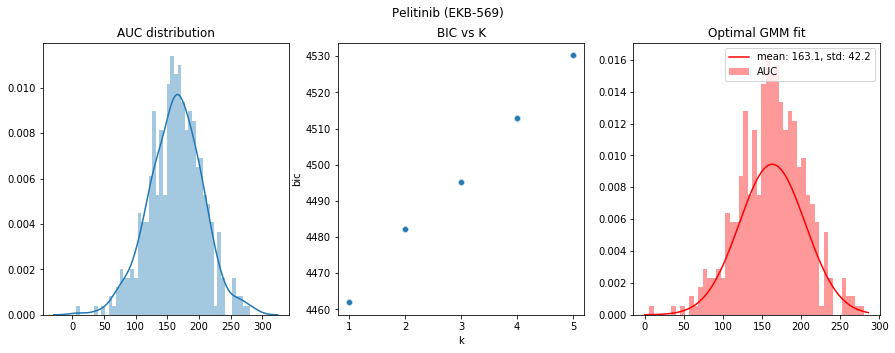

------------------------------------------------
Inhibitor:  PHA-665752
------------------------------------------------
Number of assays (aucs): 435
Optimal K: 2 [BIC=4450.1]
GMM fit:
	Mixture Weights: array([ 0.60141115,  0.39858885])
	Means: array([ 234.25505066,  193.57939407])
	Variances: array([  771.75489413,  1905.05584722])
Class counts: ['class 0: 322', 'class 1: 113']


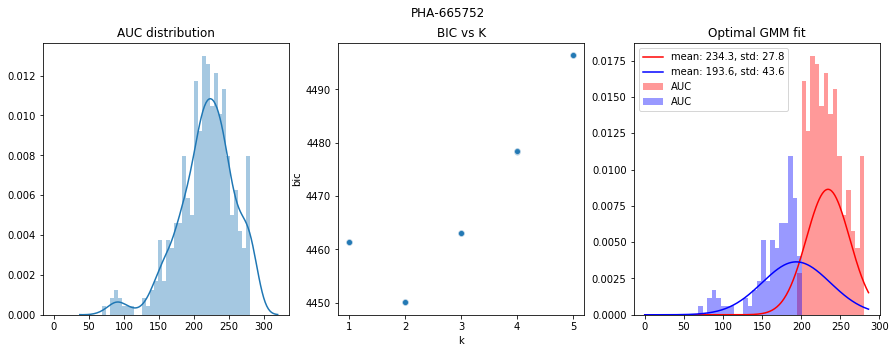

------------------------------------------------
Inhibitor:  PHT-427
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 4 [BIC=3020.4]
GMM fit:
	Mixture Weights: array([ 0.44847627,  0.04595243,  0.22465185,  0.28091945])
	Means: array([ 276.77316975,  155.76442426,  286.26924128,  242.46003986])
	Variances: array([  6.42795184e+01,   3.85258119e+03,   1.30092006e-03,
         4.73604414e+02])
Class counts: ['class 0: 202', 'class 1: 14', 'class 2: 95', 'class 3: 109']


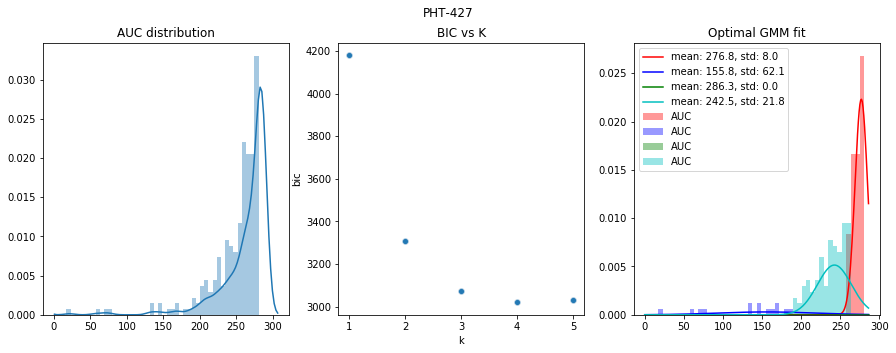

------------------------------------------------
Inhibitor:  PI-103
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4592.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 140.35699877])
	Variances: array([ 2356.66433103])
Class counts: ['class 0: 432']


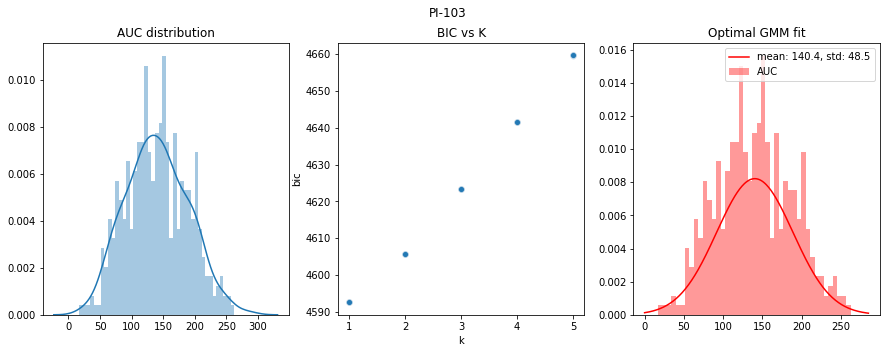

------------------------------------------------
Inhibitor:  Ponatinib (AP24534)
------------------------------------------------
Number of assays (aucs): 460
Optimal K: 2 [BIC=5002.3]
GMM fit:
	Mixture Weights: array([ 0.5210963,  0.4789037])
	Means: array([ 113.26869384,  193.48173313])
	Variances: array([ 1281.09410219,  1604.4604425 ])
Class counts: ['class 0: 248', 'class 1: 212']


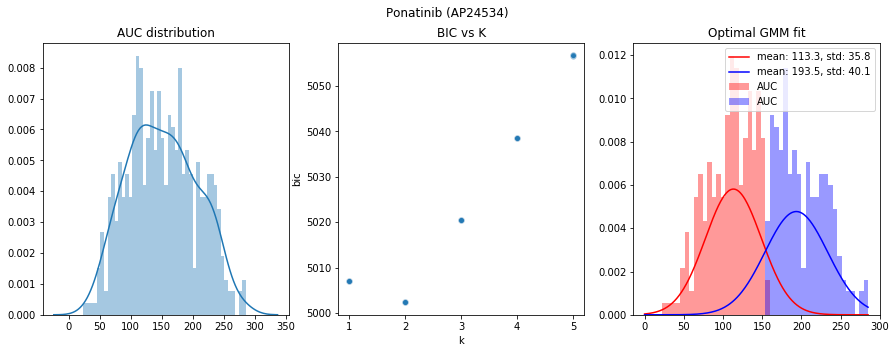

------------------------------------------------
Inhibitor:  PP242
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 1 [BIC=4575.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 139.92493152])
	Variances: array([ 2264.95055139])
Class counts: ['class 0: 432']


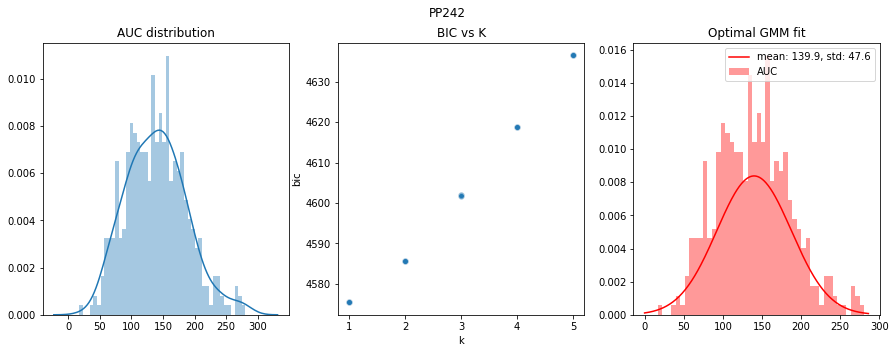

------------------------------------------------
Inhibitor:  PRT062607
------------------------------------------------
Number of assays (aucs): 425
Optimal K: 1 [BIC=4441.1]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 193.47178256])
	Variances: array([ 1965.04677792])
Class counts: ['class 0: 425']


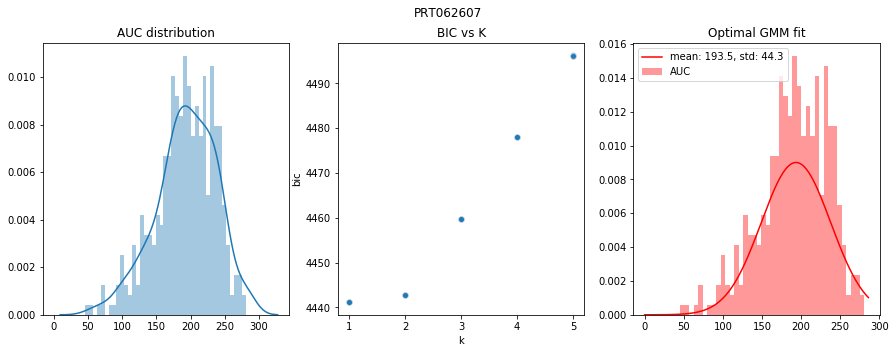

------------------------------------------------
Inhibitor:  Quizartinib (AC220)
------------------------------------------------
Number of assays (aucs): 450
Optimal K: 1 [BIC=4840.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 150.78371259])
	Variances: array([ 2673.21568139])
Class counts: ['class 0: 450']


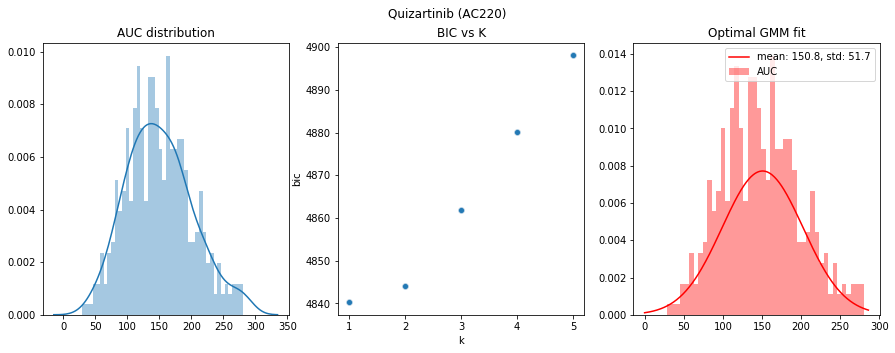

------------------------------------------------
Inhibitor:  RAF265 (CHIR-265)
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 1 [BIC=4478.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 165.39792308])
	Variances: array([ 2042.13577533])
Class counts: ['class 0: 427']


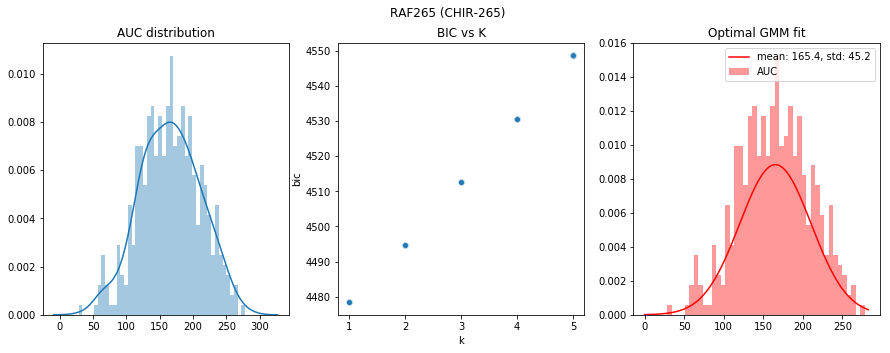

------------------------------------------------
Inhibitor:  Rapamycin
------------------------------------------------
Number of assays (aucs): 478
Optimal K: 1 [BIC=5206.2]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 175.98806926])
	Variances: array([ 3065.14456621])
Class counts: ['class 0: 478']


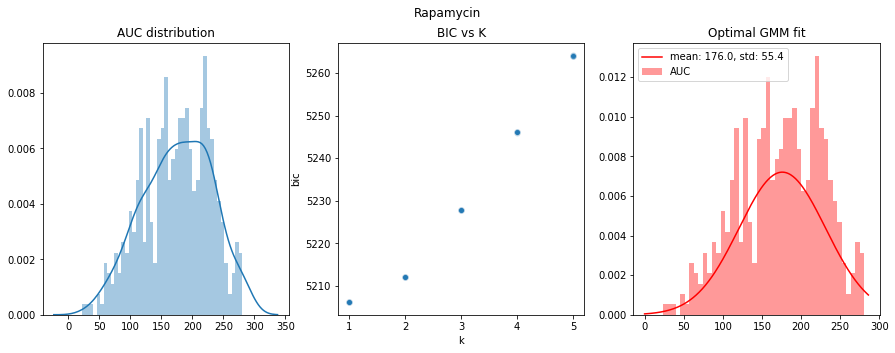

------------------------------------------------
Inhibitor:  Regorafenib (BAY 73-4506)
------------------------------------------------
Number of assays (aucs): 423
Optimal K: 1 [BIC=4283.6]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 188.48395235])
	Variances: array([ 1422.67755284])
Class counts: ['class 0: 423']


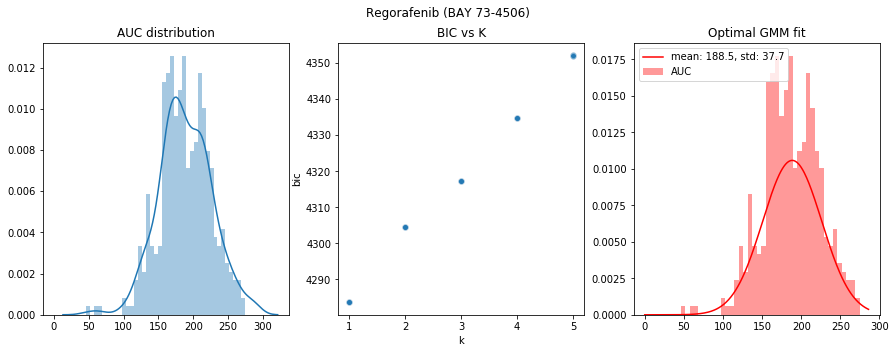

------------------------------------------------
Inhibitor:  Roscovitine (CYC-202)
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 5 [BIC=4062.0]
GMM fit:
	Mixture Weights: array([ 0.34134609,  0.23431548,  0.09112542,  0.01277575,  0.32043727])
	Means: array([ 279.33877999,  243.18779706,  189.49961771,   65.05391433,
        261.51162005])
	Variances: array([   32.08005123,   264.79389502,  1047.78826706,  1176.15506848,
          93.40719841])
Class counts: ['class 0: 159', 'class 1: 88', 'class 2: 33', 'class 3: 5', 'class 4: 153']


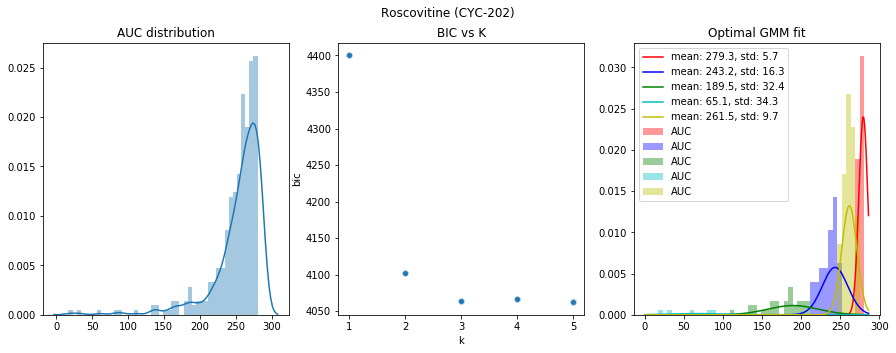

------------------------------------------------
Inhibitor:  Ruxolitinib (INCB018424)
------------------------------------------------
Number of assays (aucs): 475
Optimal K: 3 [BIC=4700.5]
GMM fit:
	Mixture Weights: array([ 0.07944077,  0.44450288,  0.47605634])
	Means: array([ 174.7215596 ,  258.90372332,  220.15762164])
	Variances: array([ 2042.03146949,   339.18182279,   509.02343414])
Class counts: ['class 0: 21', 'class 1: 222', 'class 2: 232']


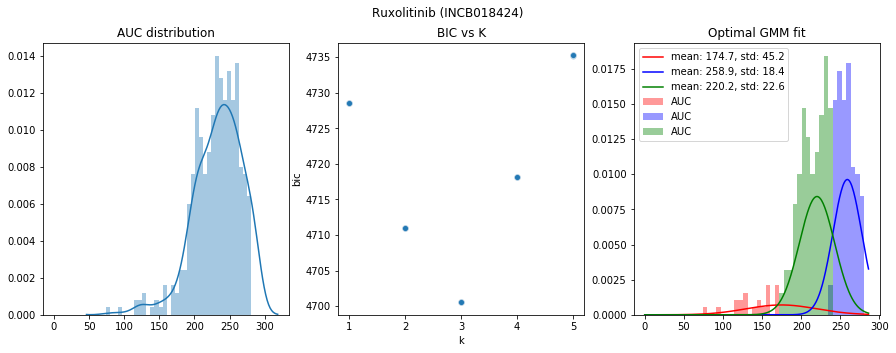

------------------------------------------------
Inhibitor:  S31-201
------------------------------------------------
Number of assays (aucs): 420
Optimal K: 3 [BIC=4391.3]
GMM fit:
	Mixture Weights: array([ 0.43262245,  0.16071835,  0.4066592 ])
	Means: array([ 257.23533086,  155.34217268,  210.14513733])
	Variances: array([  339.71738007,  3142.785433  ,  1007.85726447])
Class counts: ['class 0: 199', 'class 1: 39', 'class 2: 182']


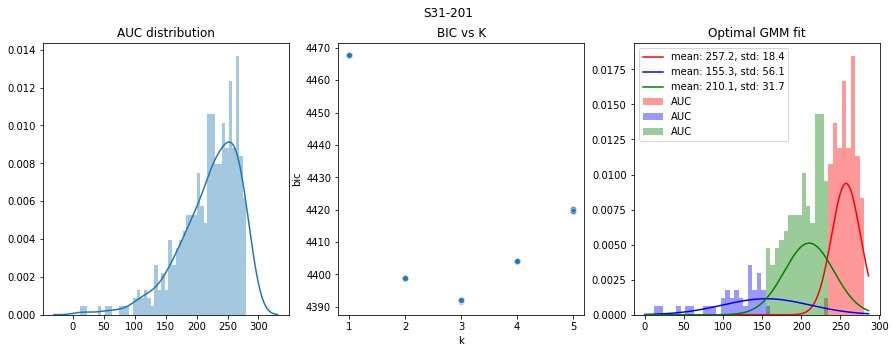

------------------------------------------------
Inhibitor:  Saracatinib (AZD0530)
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 1 [BIC=4366.8]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 213.96381985])
	Variances: array([ 1774.44701469])
Class counts: ['class 0: 422']


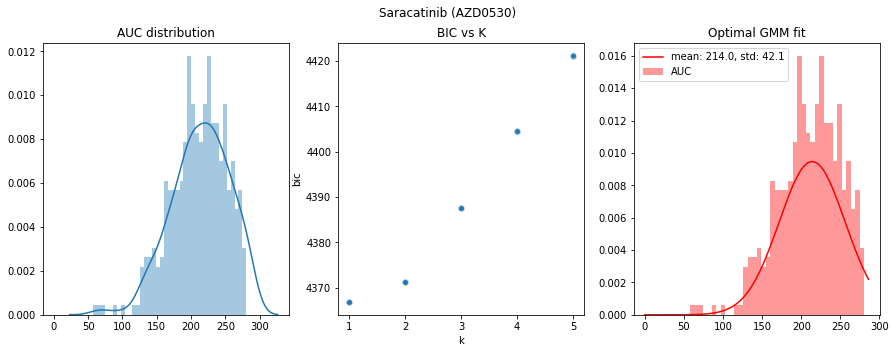

------------------------------------------------
Inhibitor:  SB-431542
------------------------------------------------
Number of assays (aucs): 437
Optimal K: 3 [BIC=4314.5]
GMM fit:
	Mixture Weights: array([ 0.50214701,  0.39441584,  0.10343716])
	Means: array([ 268.19406605,  231.31765929,  153.92493116])
	Variances: array([  164.59264623,   593.21279029,  2619.55030895])
Class counts: ['class 0: 243', 'class 1: 158', 'class 2: 36']


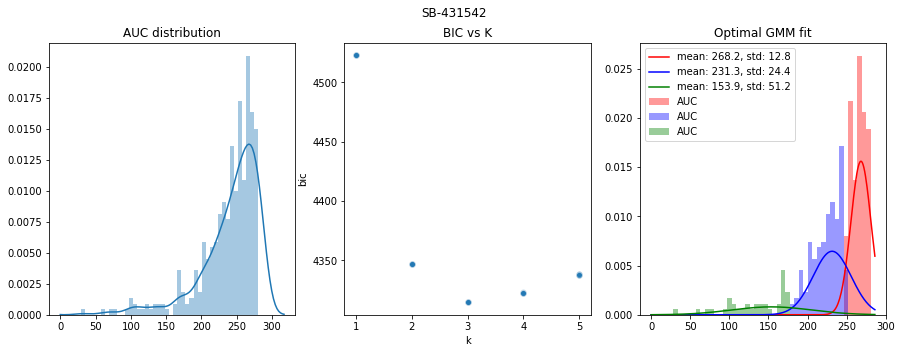

------------------------------------------------
Inhibitor:  Selumetinib (AZD6244)
------------------------------------------------
Number of assays (aucs): 433
Optimal K: 5 [BIC=4831.9]
GMM fit:
	Mixture Weights: array([ 0.29483783,  0.19407319,  0.22860138,  0.12914925,  0.15333835])
	Means: array([ 239.00738032,  151.06440004,  175.89948627,  281.77366842,
         95.63644597])
	Variances: array([  557.58173208,  1987.53537673,  1293.20958498,    27.70942088,
        1286.40737068])
Class counts: ['class 0: 141', 'class 1: 47', 'class 2: 113', 'class 3: 61', 'class 4: 71']


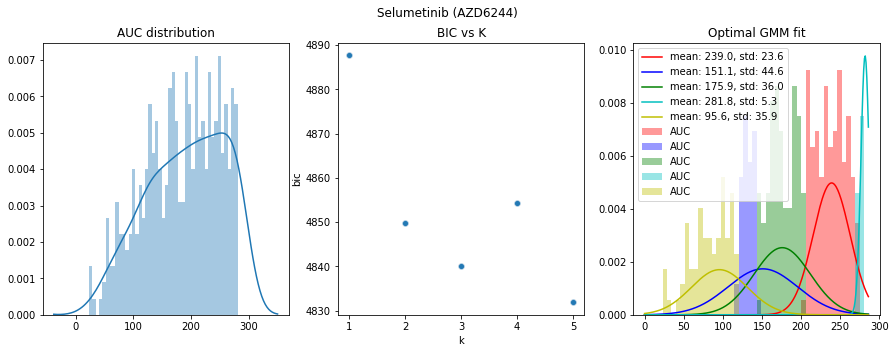

------------------------------------------------
Inhibitor:  SGX-523
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 4 [BIC=4097.7]
GMM fit:
	Mixture Weights: array([ 0.34766469,  0.02532665,  0.21454865,  0.41246001])
	Means: array([ 250.78847195,  104.54014774,  218.43878923,  275.3699201 ])
	Variances: array([  201.48519958,  1028.37441111,   678.82325862,    69.73373369])
Class counts: ['class 0: 151', 'class 1: 11', 'class 2: 73', 'class 3: 197']


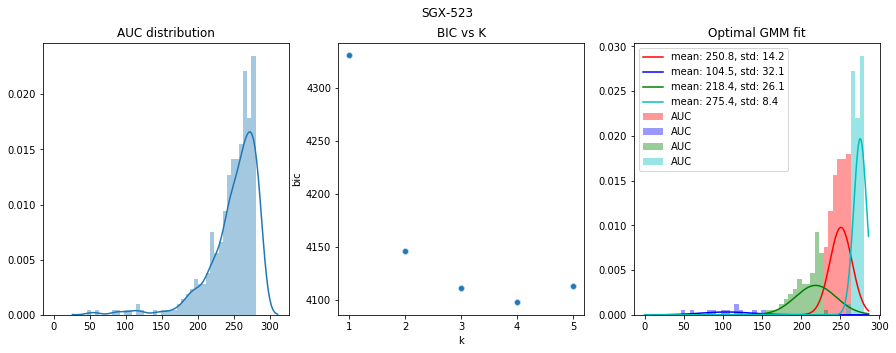

------------------------------------------------
Inhibitor:  SNS-032 (BMS-387032)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4374.3]
GMM fit:
	Mixture Weights: array([ 0.36466961,  0.63533039])
	Means: array([ 130.76451788,   88.47916265])
	Variances: array([ 1915.14033014,   536.55419975])
Class counts: ['class 0: 105', 'class 1: 331']


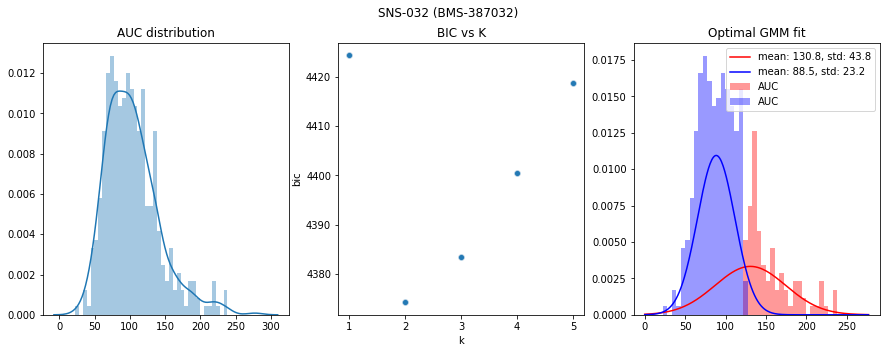

------------------------------------------------
Inhibitor:  Sorafenib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([ 0.57523925,  0.42476075])
	Means: array([ 220.70232329,  160.43097496])
	Variances: array([ 1141.4331894 ,  2577.01244736])
Class counts: ['class 0: 332', 'class 1: 173']


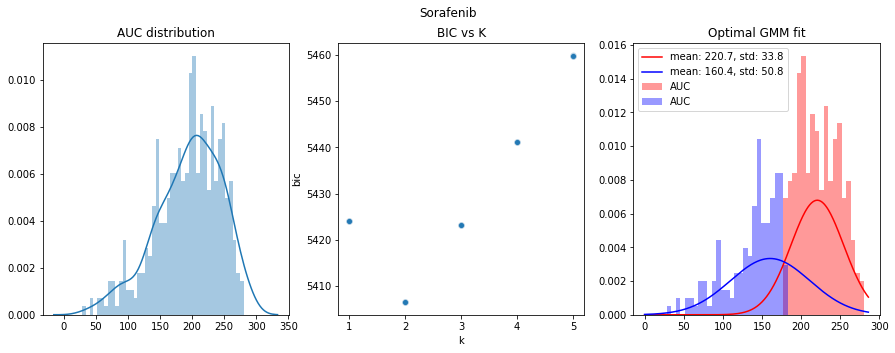

------------------------------------------------
Inhibitor:  STO609
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 4 [BIC=3949.4]
GMM fit:
	Mixture Weights: array([ 0.24559015,  0.29122179,  0.06164706,  0.401541  ])
	Means: array([ 281.59207751,  237.36187621,  197.75845702,  263.51534495])
	Variances: array([   15.11630466,   343.83919532,  1347.33681759,    73.58564766])
Class counts: ['class 0: 118', 'class 1: 114', 'class 2: 17', 'class 3: 187']


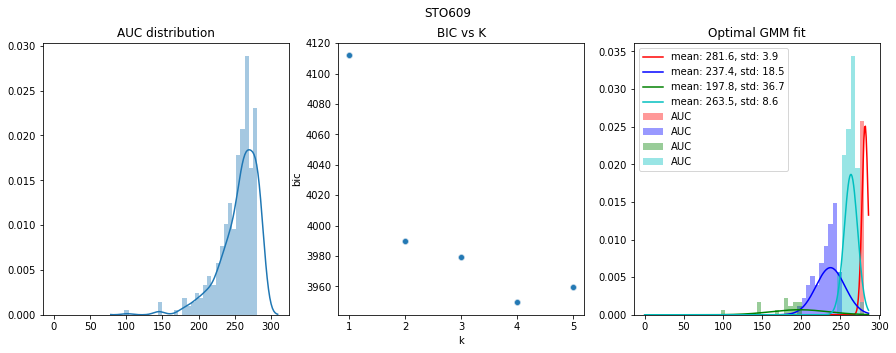

------------------------------------------------
Inhibitor:  SU11274
------------------------------------------------
Number of assays (aucs): 419
Optimal K: 1 [BIC=4235.8]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 218.06240027])
	Variances: array([ 1397.7889963])
Class counts: ['class 0: 419']


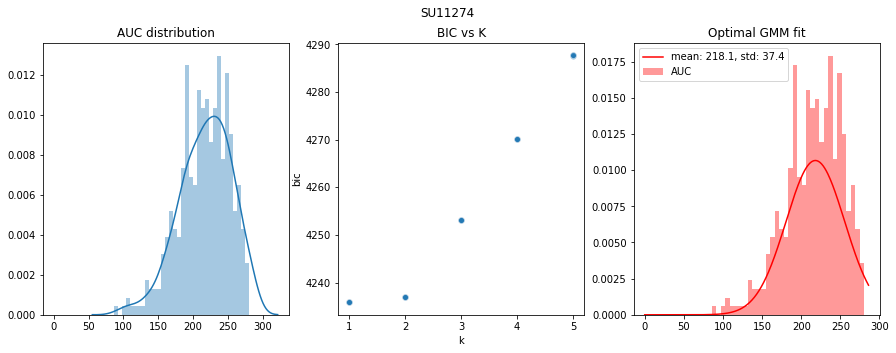

------------------------------------------------
Inhibitor:  Sunitinib
------------------------------------------------
Number of assays (aucs): 501
Optimal K: 2 [BIC=5264.8]
GMM fit:
	Mixture Weights: array([ 0.43124777,  0.56875223])
	Means: array([ 170.94741204,  225.67490839])
	Variances: array([ 2018.09015565,   950.86260094])
Class counts: ['class 0: 179', 'class 1: 322']


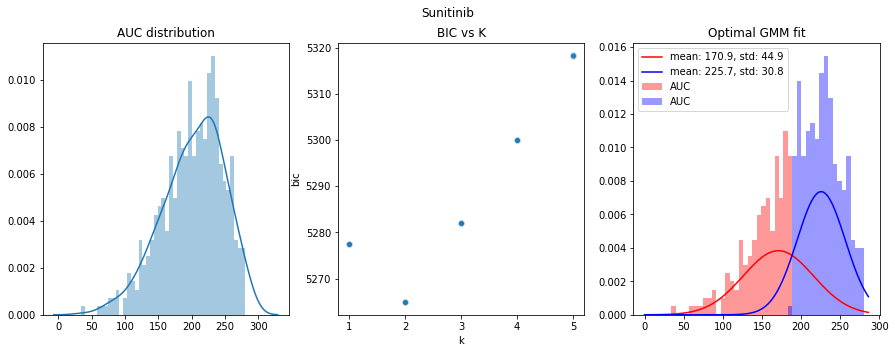

------------------------------------------------
Inhibitor:  TG100-115
------------------------------------------------
Number of assays (aucs): 429
Optimal K: 3 [BIC=4175.4]
GMM fit:
	Mixture Weights: array([ 0.49170846,  0.06682865,  0.44146288])
	Means: array([ 228.43171408,  170.16320001,  263.28317478])
	Variances: array([  513.80887851,  2840.83713212,   222.1720587 ])
Class counts: ['class 0: 202', 'class 1: 16', 'class 2: 211']


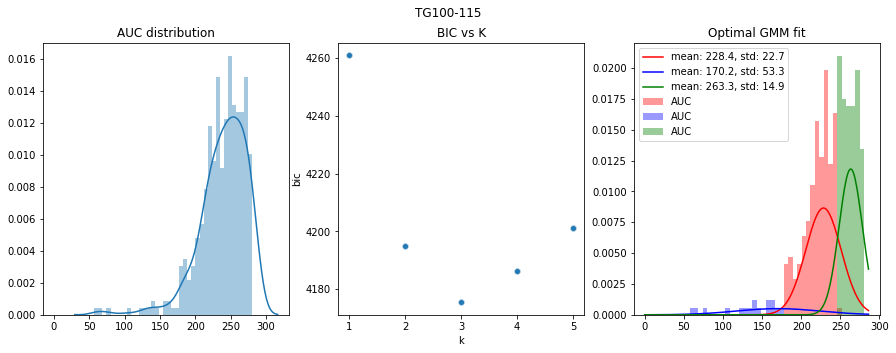

------------------------------------------------
Inhibitor:  Tivozanib (AV-951)
------------------------------------------------
Number of assays (aucs): 421
Optimal K: 2 [BIC=4648.1]
GMM fit:
	Mixture Weights: array([ 0.50471566,  0.49528434])
	Means: array([ 124.67058888,  215.39570995])
	Variances: array([ 1527.39653298,  1553.32591854])
Class counts: ['class 0: 213', 'class 1: 208']


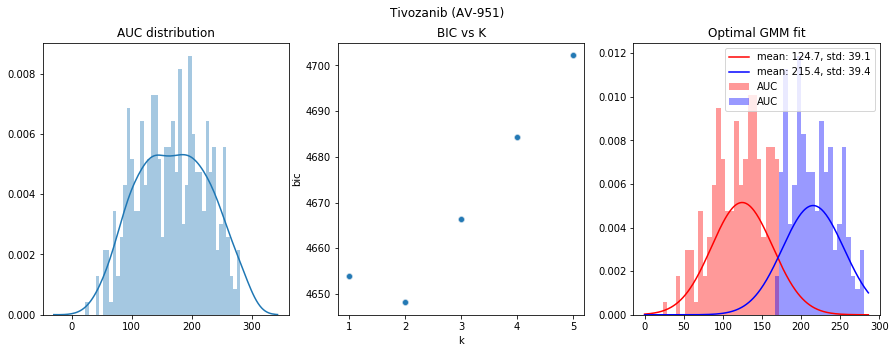

------------------------------------------------
Inhibitor:  Tofacitinib (CP-690550)
------------------------------------------------
Number of assays (aucs): 434
Optimal K: 2 [BIC=4402.2]
GMM fit:
	Mixture Weights: array([ 0.60399973,  0.39600027])
	Means: array([ 232.02455827,  193.93273443])
	Variances: array([  661.97465245,  1981.27750847])
Class counts: ['class 0: 318', 'class 1: 116']


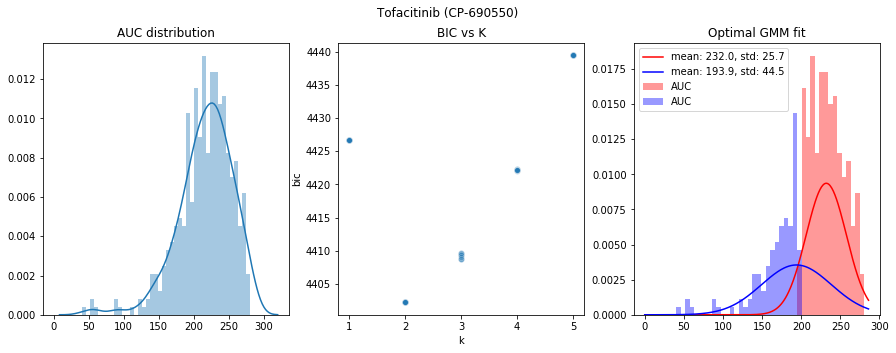

------------------------------------------------
Inhibitor:  Tozasertib (VX-680)
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4440.2]
GMM fit:
	Mixture Weights: array([ 0.33708369,  0.66291631])
	Means: array([ 184.24468239,  227.08966462])
	Variances: array([ 2144.77726346,   718.34101867])
Class counts: ['class 0: 84', 'class 1: 352']


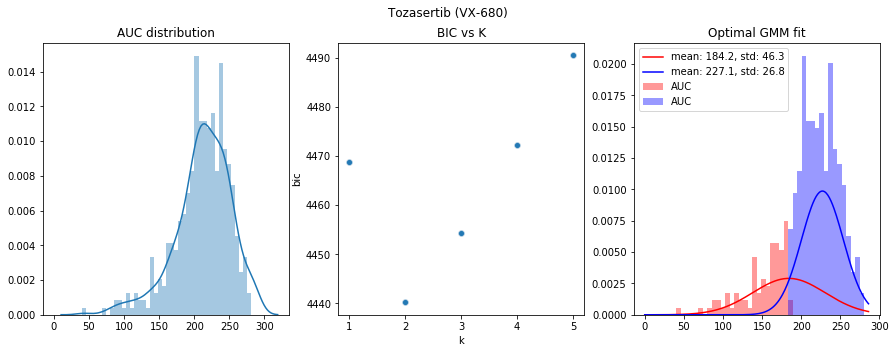

------------------------------------------------
Inhibitor:  Trametinib (GSK1120212)
------------------------------------------------
Number of assays (aucs): 454
Optimal K: 2 [BIC=5063.9]
GMM fit:
	Mixture Weights: array([ 0.53637806,  0.46362194])
	Means: array([  86.55306617,  184.25571516])
	Variances: array([ 1299.10847577,  2471.94396084])
Class counts: ['class 0: 251', 'class 1: 203']


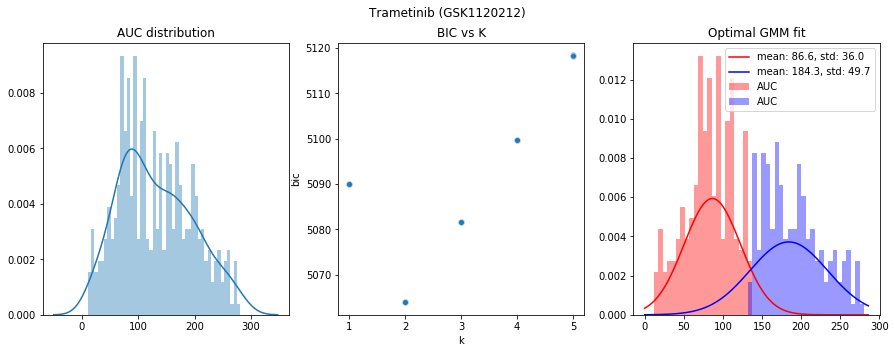

------------------------------------------------
Inhibitor:  Vandetanib (ZD6474)
------------------------------------------------
Number of assays (aucs): 491
Optimal K: 5 [BIC=5054.9]
GMM fit:
	Mixture Weights: array([ 0.24277183,  0.17797902,  0.23858791,  0.01892994,  0.3217313 ])
	Means: array([ 273.2401891 ,  183.17070291,  215.88501221,   66.90958991,
        235.14359563])
	Variances: array([  112.61445278,  1085.89953414,   814.30620396,  1223.93093113,
         296.12915597])
Class counts: ['class 0: 132', 'class 1: 73', 'class 2: 70', 'class 3: 9', 'class 4: 207']


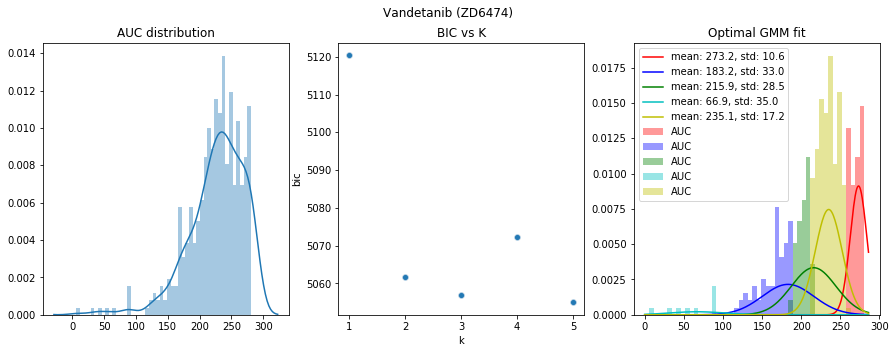

------------------------------------------------
Inhibitor:  Vargetef
------------------------------------------------
Number of assays (aucs): 428
Optimal K: 1 [BIC=4615.9]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 182.10557169])
	Variances: array([ 2748.30058672])
Class counts: ['class 0: 428']


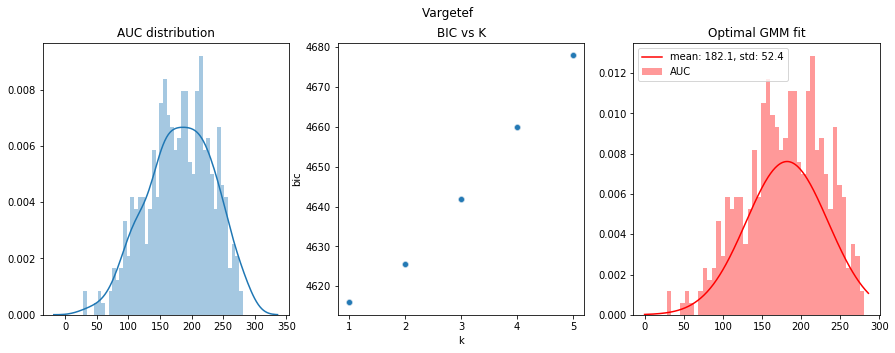

------------------------------------------------
Inhibitor:  Vatalanib (PTK787)
------------------------------------------------
Number of assays (aucs): 432
Optimal K: 2 [BIC=4367.9]
GMM fit:
	Mixture Weights: array([ 0.27943071,  0.72056929])
	Means: array([ 186.45016304,  232.81379574])
	Variances: array([ 2804.42609938,   625.62022354])
Class counts: ['class 0: 69', 'class 1: 363']


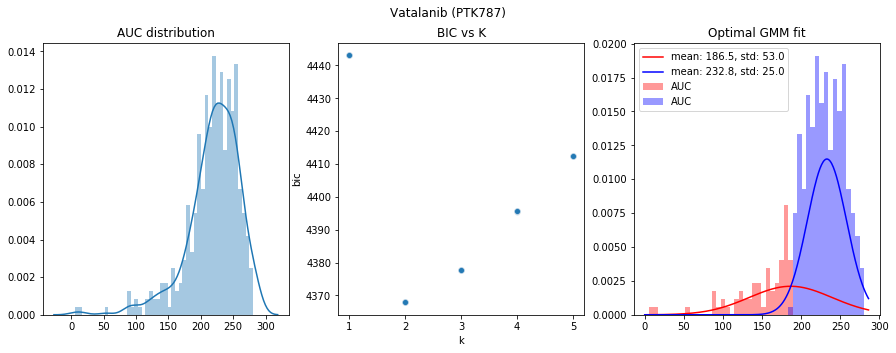

------------------------------------------------
Inhibitor:  Vismodegib (GDC-0449)
------------------------------------------------
Number of assays (aucs): 427
Optimal K: 4 [BIC=2723.7]
GMM fit:
	Mixture Weights: array([ 0.41815136,  0.17939973,  0.3654429 ,  0.03700601])
	Means: array([ 286.10381105,  250.7232635 ,  277.85416868,  114.57496376])
	Variances: array([  6.45716189e-02,   2.63051078e+02,   3.24342284e+01,
         3.72615206e+03])
Class counts: ['class 0: 186', 'class 1: 69', 'class 2: 157', 'class 3: 15']


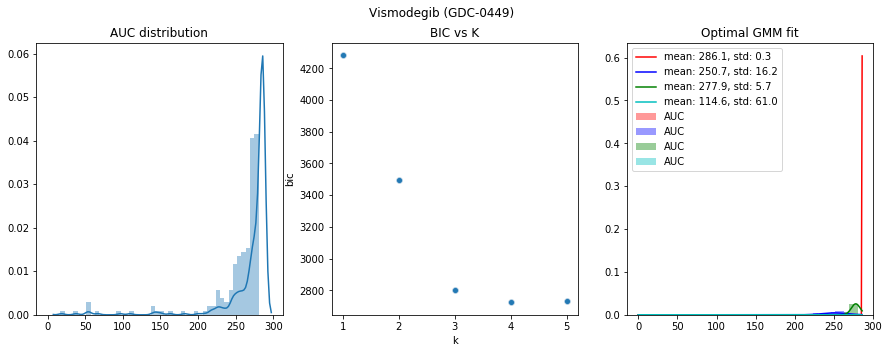

------------------------------------------------
Inhibitor:  VX-745
------------------------------------------------
Number of assays (aucs): 436
Optimal K: 2 [BIC=4599.1]
GMM fit:
	Mixture Weights: array([ 0.38003257,  0.61996743])
	Means: array([ 159.43861583,  217.73189101])
	Variances: array([ 2245.24318799,   972.28550644])
Class counts: ['class 0: 122', 'class 1: 314']


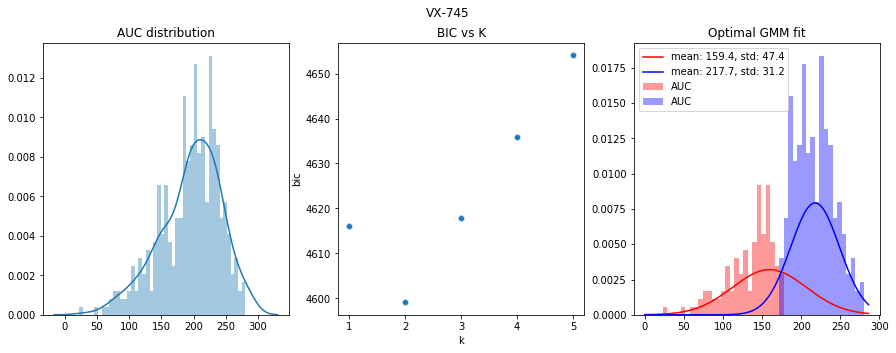

------------------------------------------------
Inhibitor:  XAV-939
------------------------------------------------
Number of assays (aucs): 422
Optimal K: 5 [BIC=4216.0]
GMM fit:
	Mixture Weights: array([ 0.28391022,  0.17579043,  0.03468212,  0.22801404,  0.2776032 ])
	Means: array([ 280.62509328,  189.72065053,  138.2949221 ,  223.64862867,
        259.33295564])
	Variances: array([   27.61396943,  1186.28896256,  3551.45313657,   477.9013666 ,
         152.13634229])
Class counts: ['class 0: 134', 'class 1: 66', 'class 2: 4', 'class 3: 102', 'class 4: 116']


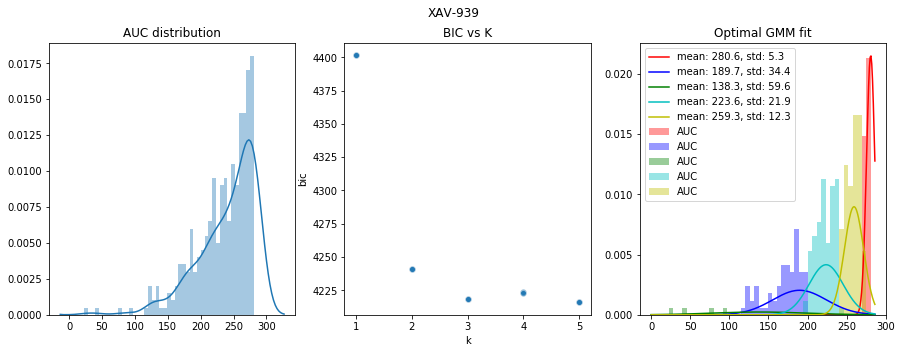

------------------------------------------------
Inhibitor:  YM-155
------------------------------------------------
Number of assays (aucs): 438
Optimal K: 4 [BIC=4293.2]
GMM fit:
	Mixture Weights: array([ 0.24304245,  0.31299131,  0.38002558,  0.06394066])
	Means: array([ 279.67663695,  215.99779497,  249.57166922,  183.25867319])
	Variances: array([   34.04759536,   680.67941328,   266.35817305,  2261.36295063])
Class counts: ['class 0: 119', 'class 1: 132', 'class 2: 176', 'class 3: 11']


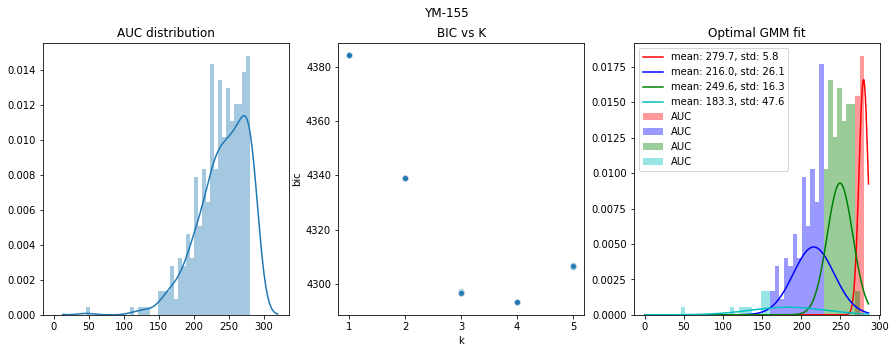

In [279]:
for inhib in aml_aucs.inhibitor.unique(): 
    inhib_dat = aml_aucs[aml_aucs.inhibitor == inhib]
    if inhib_dat.shape[0] > 400: 
        print('------------------------------------------------')
        print('Inhibitor:  %s' %inhib)
        print('------------------------------------------------')
        AUCS =  inhib_dat.auc.values.reshape(-1,1)
        test_multimodal_fits(AUCS, ntests=10, kmax=6, inhib=inhib, plot=True)
    

# Save subset of okay'd data

In [ ]:
okay_data = ['YM-155', 'Vandetanib (ZD6474)', 'Trametinib (GSK1120212)', 'Sunitinib','Sorafenib', 'Selumetinib (AZD6244)', 'Nilotinib', 'JAK Inhibitor I', 'Pazopanib (GW786034)', 'Elesclomol', 'Dasatinib']

dat = aml_aucs[aml_aucs.inhibitor.isin(okay_data)]
dat.to_csv('./../data/beatAML_AUCs_subset.csv')

# Test HNSCC distribution

The next step is to ask, can we model these drug responses across cancer types? As in, are the distributions that are well defined by the beatAML similarly define the HNSCC distribution? 

We will try to test this by setting our null hypothesis as: 

Let X be the underlying set distribution such that: 
$$ AUC_{beatAML} \in X $$  

$$ H_0: AUC_{HNSCC} \in X $$ 
and 
$$ H_1: AUC_{HNSCC} \notin X $$ 

We will use permutation testing, and reject cases where `alpha=0.05`. 


In [244]:
HNSCC_all = pd.read_csv('./../data/HNSCC_all_functional_data.csv')
HNSCC_auc = HNSCC_all[['lab_id','inhibitor','auc','call']].drop_duplicates()
HNSCC_auc.head()

lab_id            inhibitor       auc  call
0   10004           JQ1;BEZ235  1.044426   int
1   10004            Lucitanib  2.809226   res
2   10004          Resveratrol  2.794546   int
3   10004  Pelitinib (EKB-569)  1.221167  sens
4   10004         Bicalutamide  2.742498   int

In [251]:
AML_Dasatinib = aml_aucs[aml_aucs['inhibitor'] == 'Sorafenib']
print('Number of AML Sorafenib assays: %d' %len(AML_Dasatinib))
AML_Dasatinib.head()

Number of AML Sorafenib assays: 505


inhibitor    lab_id         auc
427287  Sorafenib  11-00261  232.933886
427294  Sorafenib  11-00487  181.911965
427301  Sorafenib  12-00023  189.034206
427308  Sorafenib  12-00032  184.248305
427315  Sorafenib  12-00066  171.013986

In [252]:
HNSCC_Dasatinib = HNSCC_auc[HNSCC_auc['inhibitor'] == 'Sorafenib'].drop_duplicates()
print('Number of HNSCC Sorafenib assays: %d' %len(HNSCC_Dasatinib))
HNSCC_Dasatinib.head()

Number of HNSCC Sorafenib assays: 17


lab_id  inhibitor       auc call
129    10004  Sorafenib  2.731822  int
2475   10139  Sorafenib  2.707063  int
4821   10308  Sorafenib  2.812098  res
6015   10309  Sorafenib  2.616760  int
7209   10314  Sorafenib  2.564023  int

------------------------------------------------
Inhibitor:  AML_Dasatinib
------------------------------------------------
Number of assays (aucs): 505
Optimal K: 2 [BIC=5406.4]
GMM fit:
	Mixture Weights: array([ 0.57523925,  0.42476075])
	Means: array([ 220.70232329,  160.43097496])
	Variances: array([ 1141.4331894 ,  2577.01244736])
Class counts: ['class 0: 332', 'class 1: 173']


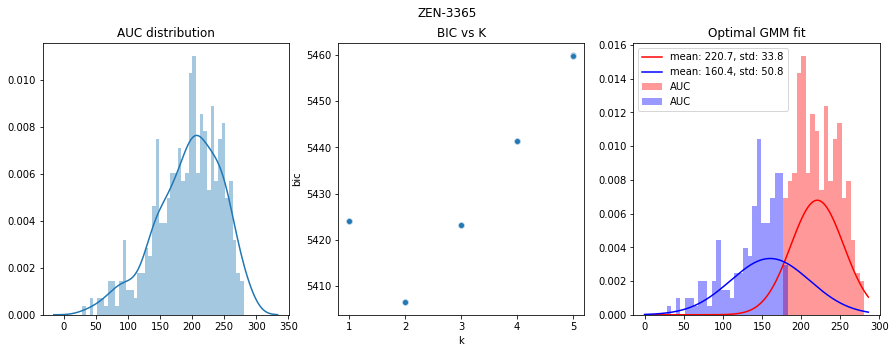

------------------------------------------------
Inhibitor:  HNSCC_Dasatinib
------------------------------------------------
Number of assays (aucs): 17
Optimal K: 1 [BIC=151.4]
GMM fit:
	Mixture Weights: array([ 1.])
	Means: array([ 259.10442709])
	Variances: array([ 310.30304888])
Class counts: ['class 0: 17']


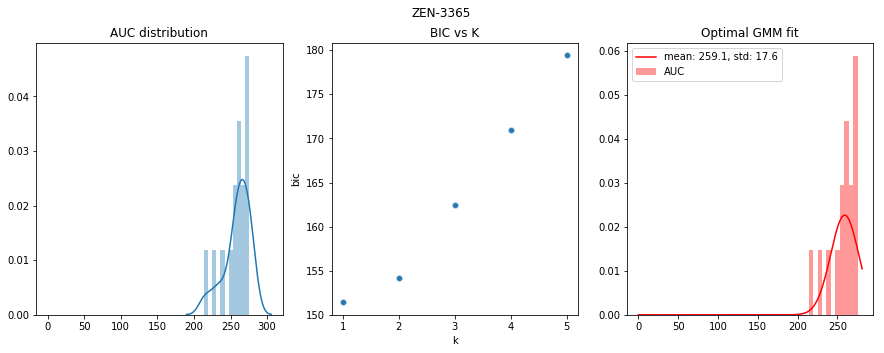

In [256]:
print('------------------------------------------------')
print('Inhibitor:  %s' %'AML_Dasatinib')
print('------------------------------------------------')
aml_=AML_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(aml_, ntests=10, kmax=6, inhib=inhib, plot=True)

print('------------------------------------------------')
print('Inhibitor:  %s' %'HNSCC_Dasatinib')
print('------------------------------------------------')
hnscc_=100*HNSCC_Dasatinib.auc.values.reshape(-1,1)
c = test_multimodal_fits(hnscc_, ntests=10, kmax=6, inhib=inhib, plot=True)

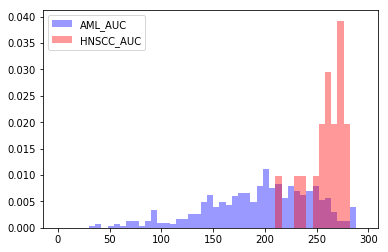

In [265]:
nbins=50
bin_ = np.arange(0,300,300/nbins)

plt.figure()
plt.hist(aml_,color='blue',label='AML_AUC',normed=True,alpha=0.4,bins=bin_)
plt.hist(hnscc_,color='red',label='HNSCC_AUC',normed=True,alpha=0.4,bins=bin_)
plt.legend()
plt.show()

In [277]:
def permutation_test(x, y, n=1e5, verbose=True, return_prob=True, alpha=0.05):
    '''
    two tailed permutation test to see if y is apart of same model as x 
    
    returns the probability that y is not drawn from the same underlying model (or True if prob > 0.05 and return_prob=True)
    '''
    
    delta_mean = np.abs( np.mean(x) - np.mean(y) )
    permutation_means = []

    for i in range(int(n)):
        if (i % 333 == 0) and verbose: print('Running permutations...[%.2f%%]' %(i/n*100), end='\r')
        perms = np.random.permutation(np.append(x,y))
        perm_y = perms[:len(y)]
        perm_x = perms[len(y):]
        permutation_means.append(np.abs(np.mean(perm_y) - np.mean(perm_x)))

    pval = np.sum( permutation_means >= delta_mean ) / len( permutation_means )
    return pval if return_prob else pval >= alpha

In [278]:
pval = permutation_test(aml_, hnscc_, n=1e6, verbose=True, return_prob=True)

print('Dasatinib permutation test p-value: %f' %pval)

Dasatinib permutation test p-value: 0.000002


# Drug response associated mutations 



In [280]:
aml_var_all = pd.read_csv('./../data/vizome_beatAML_variants.csv', skiprows=[0,1,2])
#[aml_var_all.tumor_only == True]
aml_var = aml_var_all.dropna()[['sample_id', 'gene', 'chr','start','end','ref','alt','variant','sift']]

aml_var = aml_var.rename(columns={'sample_id':'lab_id'})

print(aml_var.head())

print(aml_var[['chr','start','end','ref','alt']].head())

print('Number of genes mutated: %d' %len(aml_var.gene.unique()))
print('Number of unique mutations: %d' %aml_var[['chr','start','end','ref','alt']].drop_duplicates().shape[0])

mut_cnt = aml_var.groupby('gene').count()['lab_id'].sort_values()
mult_patients = mut_cnt.index[mut_cnt > 20]
#aml_variants = aml_var[aml_var['lab_id'].isin(mult_patients)]

shared_mutations = [x for x in mult_patients]
print(shared_mutations)
print(aml_var.groupby('gene').count()['lab_id'].sort_values())

aml_var = aml_var[aml_var['gene'].isin(shared_mutations)]

aml_var.head()

     lab_id      gene chr    start      end ref alt           variant  \
0  14-00141  C1orf170   1   914477   914477   C   T  missense_variant   
3  13-00515    UBE2J2   1  1192625  1192625   T   G  missense_variant   
5  14-00244    ATAD3B   1  1417649  1417649   T   G  missense_variant   
7  15-00900    ATAD3A   1  1463113  1463113   T   A  missense_variant   
8  15-00988    ATAD3A   1  1463113  1463113   T   A  missense_variant   

                sift  
0    tolerated(0.12)  
3  deleterious(0.05)  
5       tolerated(1)  
7     deleterious(0)  
8     deleterious(0)  
  chr    start      end ref alt
0   1   914477   914477   C   T
3   1  1192625  1192625   T   G
5   1  1417649  1417649   T   G
7   1  1463113  1463113   T   A
8   1  1463113  1463113   T   A
Number of genes mutated: 298
Number of unique mutations: 338
['U2AF1', 'JAK2', 'IDH1', 'NRAS', 'DNMT3A']
gene
MED16      1
MGA        1
MIER2      1
MRPL23     1
MST4       1
          ..
U2AF1     21
JAK2      23
IDH1      27
NRAS

lab_id  gene chr      start        end ref alt           variant  \
268  14-00092  NRAS   1  115256528  115256528   T   G  missense_variant   
269  16-00118  NRAS   1  115256528  115256528   T   G  missense_variant   
270  16-00510  NRAS   1  115256528  115256528   T   G  missense_variant   
275  13-00420  NRAS   1  115256530  115256530   G   T  missense_variant   
276  14-00064  NRAS   1  115256530  115256530   G   T  missense_variant   

                  sift  
268     deleterious(0)  
269     deleterious(0)  
270     deleterious(0)  
275  deleterious(0.01)  
276  deleterious(0.01)

In [281]:
# convert variants to matrix format 

genes = pd.Series( aml_var.gene.unique() )

res = []
for lab_id in aml_var.lab_id.unique(): 
    D = aml_var[aml_var['lab_id'] == lab_id]
    x = genes.isin( D['gene'] ).tolist()
    res.append( [lab_id] + [str(int(xx)) for xx in x] )

res = pd.DataFrame( res, columns=['lab_id'] + genes.tolist() )

res.head()

MAT_VAR = res 

print('matrix variant shape: %s' %str(res.shape))
print(MAT_VAR.head())

matrix variant shape: (167, 6)
     lab_id NRAS DNMT3A IDH1 U2AF1 JAK2
0  14-00092    1      1    0     0    0
1  16-00118    1      0    0     0    0
2  16-00510    1      0    0     0    0
3  13-00420    1      0    1     0    0
4  14-00064    1      0    0     0    0


In [282]:
print( aml_aucs.head() )

aml_aucs['lab_id']=aml_aucs['lab_id'].astype(str)
MAT_VAR['lab_id']=MAT_VAR['lab_id'].astype(str)

aml_auc_w_var = aml_aucs.merge(right=MAT_VAR, how='inner', on=['lab_id'])
aml_auc_w_var.head(5)

                inhibitor    lab_id         auc
0   17-AAG (Tanespimycin)  12-00211  225.918025
7   17-AAG (Tanespimycin)  12-00219  135.264409
14  17-AAG (Tanespimycin)  12-00258  164.561227
21  17-AAG (Tanespimycin)  12-00262  111.555971
28  17-AAG (Tanespimycin)  12-00268  226.805281


inhibitor    lab_id         auc NRAS DNMT3A IDH1 U2AF1 JAK2
0  17-AAG (Tanespimycin)  13-00118  217.469453    0      1    0     0    0
1               A-674563  13-00118  200.671721    0      1    0     0    0
2                ABT-737  13-00118  210.841965    0      1    0     0    0
3   Afatinib (BIBW-2992)  13-00118  184.158486    0      1    0     0    0
4       AKT Inhibitor IV  13-00118  141.415353    0      1    0     0    0

Dasatinib auc and variants shape: (88, 8)
Number of assays (aucs): 88
Optimal K: 2 [BIC=982.6]
GMM fit:
	Mixture Weights: array([ 0.47590632,  0.52409368])
	Means: array([ 119.23863497,  219.31488033])
	Variances: array([  934.06293972,  1520.06524569])
Class counts: ['class 0: 42', 'class 1: 46']


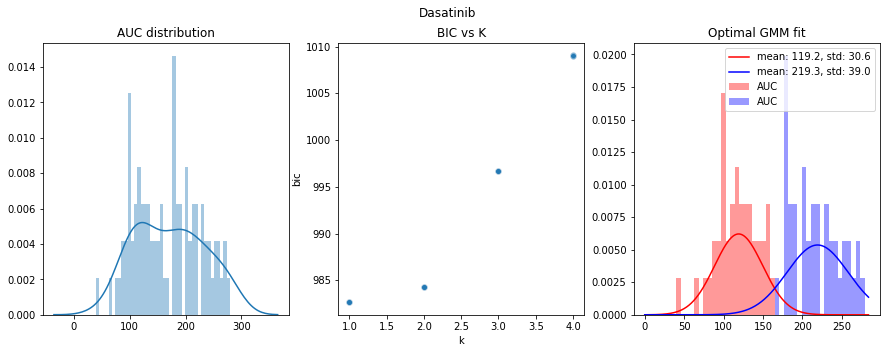

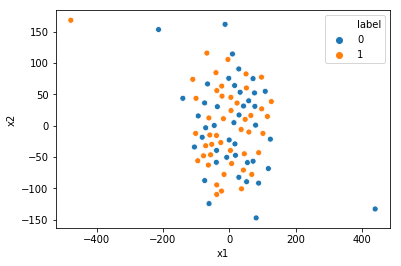

In [283]:
Dasatinib = aml_auc_w_var[aml_auc_w_var['inhibitor'] == 'Dasatinib']

print('Dasatinib auc and variants shape: %s' %str(Dasatinib.shape))

aucs = Dasatinib.auc.values.reshape(-1,1)
X = Dasatinib[genes]
Y = test_multimodal_fits(aucs, inhib='Dasatinib', override_k=2)

X_embedded = TSNE(n_components=2).fit_transform(X)
df = pd.DataFrame( {'x1':X_embedded[:,0], 'x2':X_embedded[:,1], 'label':Y} )

plt.figure() 
sbn.scatterplot(x='x1', y='x2', hue='label', data=df)
plt.show()

Elastic Net accuracy: 0.52
Elastic Net AUC: 0.50


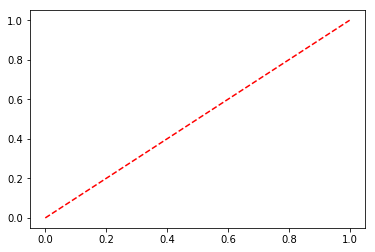

[0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 1 0 0 1 1 0 0 1 1 0 0]
Logistic Regression accuracy: 0.70
Logistic Regression AUC: 0.71


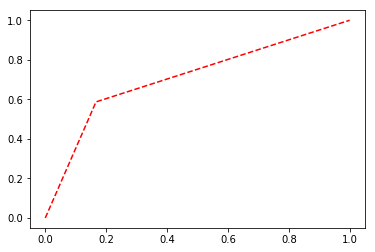

---------------------------------------------------
STATSMODEL LOGIT
---------------------------------------------------
Logistic Regression accuracy: 0.60
Logistic Regression AUC: 0.76


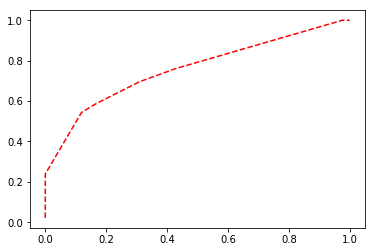

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   88
Model:                          Logit   Df Residuals:                       82
Method:                           MLE   Df Model:                            5
Date:                Tue, 24 Sep 2019   Pseudo R-squ.:                  0.2082
Time:                        22:56:55   Log-Likelihood:                -48.224
converged:                       True   LL-Null:                       -60.906
                                        LLR p-value:                 0.0001185
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5231      1.106      0.473      0.636      -1.645       2.691
x1             0.5562      1.011      0.550      0.582      -1.425       2.537
x2            -1.2607      1.044     -1.208      0.2

In [284]:
reg = ElasticNet().fit(X, Y)

yhat = reg.predict(X)

pred = (yhat > 0.5)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Elastic Net accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Elastic Net AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()



logit = LogisticRegression().fit(X,Y)

yhat = logit.predict(X)
pred = (yhat > 0.5)*1
print(pred)

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print('---------------------------------------------------')
print('STATSMODEL LOGIT')
print('---------------------------------------------------')

X2 = X.values.astype(int)
logit_sm = sm.Logit(Y, sm.add_constant(X2)).fit(method='lbfgs', maxiter=500)
yhat = logit_sm.predict(sm.add_constant(X2))

cutoff = 0.9
pred = (yhat > cutoff)*1

acc = sum([a == b for a,b in zip(pred, Y)]*1) / len(Y)
print('Logistic Regression accuracy: %.2f' %acc)

fpr, tpr, thresholds = metrics.roc_curve(Y, yhat, pos_label=1)
EN_auc = metrics.auc(fpr, tpr)
print('Logistic Regression AUC: %.2f' %EN_auc)

plt.figure()
plt.plot(fpr,tpr,'r--')
plt.show()

print( logit_sm.summary() )

#print(yhat)

#build_RF_variant_model(X,Y)